> Created on Mon May  8 08:34:55 2023 @author: Richie Bao-caDesign设计(cadesign.cn)

# 3.5-B 推理学习：概率图——贝叶斯网络

概率图（probabilistic graphical model，PGM）是一种概率模型，其中图作为一个数据结构表示随机变量间的条件依赖关系和概率分布，在应用图论的知识解决概率论相关问题同时，且能够可视化随机变量的关系从而易于理解模型结构。概率图已经发展成熟，并广泛应用到各个领域，其中系统的经典论著有*Probabilistic Graphical Models : Principles and Techniques（概率图模型原理与技术）（2009）*<sup>[1]</sup>。为了避免概率图中繁琐的计算，使用 Python 解决 PGM 问题的库也得以发展，如下表：

| 序号  | Python 库  | 库的基本情况  | 备注  |
|---|---|---|---|
| 1  | [pgmpy](https://github.com/pgmpy/pgmpy)<sup>①</sup>  | 持续更新，是；</br>使用者 $\geq $ 598人；</br>贡献者 $\geq $ 100人  | 专著，*Mastering Probabilistic Graphical Models Using Python : Master Probabilistic Graphical Models by Learning through Real-World Problems and Illustrative Code Examples in Python*<sup>[2]</sup> ；</br>[在线手册](https://pgmpy.org/)<sup>②</sup> |
| 2  | [pomegranate](https://github.com/jmschrei/pomegranate) <sup>③</sup> | 持续更新，是；</br>使用者 $\geq $ 891人；</br>贡献者 $\geq $ 64人 | [在线手册](https://github.com/jmschrei/pomegranate/tree/master/docs/tutorials) <sup>④</sup> |
| 3  | [PGM_PyLib](https://github.com/jona2510/PGM_PyLib)<sup>⑤</sup>  | 持续更新，否 | 专著，*Probabilistic Graphical Models : Principles and Applications*<sup>[3]</sup>  |
| 4  | [PyGModels](https://github.com/D-K-E/graphical-models/) <sup>⑥</sup> | 持续更新，否  | [在线手册](https://d-k-e.github.io/graphical-models/html/index.html)<sup>⑦</sup>  |
| 5  | [pyGMs](https://github.com/ihler/pyGMs) <sup>⑧</sup> |  持续更新，否  | /  |
| 6  | [pgmPy](https://github.com/indapa/pgmPy) <sup>⑨</sup> | 持续更新，否  | [课程](https://www.coursera.org/learn/probabilistic-graphical-models)<sup>⑩</sup>  |
| 7  | [pgm](https://github.com/paulorauber/pgm) <sup>⑪</sup> | 持续更新，否  | /  |


从上述 PGM 相关库的比较，目前仍在持续更新的有`pgmpy`和`pomegranate`两个库，且使用者和贡献者人数相对较多，具有在线手册或者已经出版的研究专著，因此在下述的 PGM 阐述上主要基于`pgmpy`实现，并参考 PGM 主要的论著及`pgmpy`库的手册进行解释。

## 3.5.1 基于概率模型的分类器

对于多维随机变量，且之间相互独立，如果可以由已知样本（特征）和对应的事件（分类）得每一随机变量的概率密度函数（边缘密度函数）或联合分布律，并以观测到的随机变量为条件计算后验分布，则可以用这个后验分布预测新样本的分类。例如对鸢尾花（iris）数据集，分布用[Skearn（scikit-learn）](https://scikit-learn.org/stable/modules/naive_bayes.html)<sup>⑫</sup>的`GaussianNB`方法，和自定义高斯朴素贝叶斯分类器阐述连续型随机变量概率模型的构建；并将鸢尾花数据集连续型随机变量转化为离散型随机变量，构建用于离散型随机变量分类的概率模型。

### 3.5.1.1 连续型随机变量分类器

`Sklearn`的`Naive Bayes`（朴素贝叶斯）目前集成了"Gaussian Naive Bayes"、"Multinomial Naive Bayes"、"Complement Naive Bayes"、"Bernoulli Naive Bayes"和"Categorical Naive Bayes"等算法。下面应用`GaussianNB`试验。

#### 1）`scikit-learn`的`GaussianNB`




In [29]:
import daft
from pgmpy.factors.discrete import TabularCPD
from pgmpy.models import BayesianModel

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn import preprocessing

import numpy as np
from scipy.special import logsumexp
import pandas as pd
from scipy.stats import norm

from sympy.stats import P, E, variance, Die, Normal,density
from sympy import simplify,Symbol,lambdify

读取鸢尾花数据集，打印查看数据集情况。总共有4个特征列（'sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'），每一特征对应一个随机变量，为多维随机变量。数据含3种分类结果（'setosa' 'versicolor' 'virginica'），分别对应标签0、1和2。

In [41]:
iris=load_iris()
print(f'---feature names:\n{iris.feature_names};\n---target names{iris.target_names}\n---data[:3]:\n{iris.data[:3]};\n---target:\n{iris.target}')

---feature names:
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'];
---target names['setosa' 'versicolor' 'virginica']
---data[:3]:
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]];
---target:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


直接使用集成的`GaussianNB`算法估计概率模型，并用该模型测试数据集75个观测样本，正确率为$(75-4)/75=0.946$。

In [44]:
X, y=load_iris(return_X_y=True)
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.5, random_state=0)
gnb=GaussianNB()
y_pred=gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 75 points : 4


使用集成封装后的方法不能够直接观察计算的过程，因此提取`GaussianNB`方法的主要代码行，整理如下。其中`update_mean_variance`方法用于计算用于高斯分布的样本特征均值和方差。`joint_log_likelihood`方法用于构建联合对数概率估计（joint log probability estimates）。

> `GaussianNB`方法位于`Sklearn`包的`naive_bayes.py`模块下。

In [58]:
def update_mean_variance(n_past, mu, var, X):
    if X.shape[0] == 0:
        return mu, var
    
    n_new=X.shape[0]
    new_var=np.var(X, axis=0)
    new_mu=np.mean(X, axis=0)
    
    if n_past == 0:
        return new_mu, new_var    
    
    n_total=float(n_past + n_new)
    total_mu=(n_new * new_mu + n_past * mu) / n_total
    old_ssd=n_past * var
    new_ssd=n_new * new_var
    total_ssd=old_ssd + new_ssd + (n_new * n_past / n_total) * (mu - new_mu) ** 2
    total_var=total_ssd / n_total
    
    return total_mu, total_var

def joint_log_likelihood(X,classes_,class_prior_,var_,theta_):
    joint_log_likelihood = []
    for i in range(np.size(classes_)):
        jointi = np.log(class_prior_[i])
        n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * var_[i, :]))
        n_ij -= 0.5 * np.sum(((X - theta_[i, :]) ** 2) / (var_[i, :]), 1)
        joint_log_likelihood.append(jointi + n_ij)
    
    joint_log_likelihood = np.array(joint_log_likelihood).T
    return joint_log_likelihood

In [67]:
X=X_train
y=y_train

_, n_features=X.shape
labelbin=preprocessing.LabelBinarizer()
Y=labelbin.fit_transform(y)
classes_=labelbin.classes_
n_classes=Y.shape[1]
class_log_prior_=np.full(n_classes, -np.log(n_classes))

unique_y=np.unique(y)

class_count_=np.zeros(n_classes, dtype=np.float64)
theta_=np.zeros((n_classes, n_features))
var_ = np.zeros((n_classes, n_features))

var_smoothing=1e-9
epsilon_=var_smoothing * np.var(X, axis=0).max()

for y_i in unique_y:
    i=classes_.searchsorted(y_i)
    X_i=X[y == y_i, :]
    N_i=X_i.shape[0]
    
    new_theta, new_sigma=update_mean_variance(class_count_[i],theta_[i, :],var_[i, :],X_i)
    theta_[i, :]=new_theta
    var_[i, :]=new_sigma
    class_count_[i] += N_i
    
var_[:, :] += epsilon_

class_prior_=class_count_ / class_count_.sum()
jll=joint_log_likelihood(X,classes_,class_prior_,var_,theta_)
print(jll[:3])
predicted_y=classes_[np.argmax(jll, axis=1)]
print(predicted_y)

[[   0.8762294   -32.51665712  -73.95573104]
 [-556.7018906    -5.71630183   -3.68412747]
 [-119.04667384   -5.66092211  -28.96539079]]
[0 2 1 0 1 2 1 0 2 2 2 2 0 0 2 2 0 2 0 2 2 0 0 2 0 0 0 1 2 2 0 0 0 1 1 0 0
 1 0 2 1 2 1 0 2 0 2 0 0 2 0 2 1 1 1 2 2 1 2 0 1 2 2 0 1 1 2 1 0 0 0 2 1 2
 0]


#### 2） 自定义高斯朴素贝叶斯分类器

朴素（简单）贝叶斯分类器（Naive Bayes Classifier，NBC）是基于给定类变量（分类$y$）的所有属性（对应特征的随机变量$(X_1,X_2,\cdots,X_n)$）都是独立的假设，有$P(y \mid x_1, \dots, x_n) = \frac{P(y) P(x_1, \dots, x_n \mid y)}{P(x_1, \dots, x_n)}$，及$P(x_i | y, x_1, \dots, x_{i-1}, x_{i+1}, \dots, x_n) = P(x_i | y)$，可以推导出$P(y \mid x_1, \dots, x_n) = \frac{P(y) \prod_{i=1}^{n} P(x_i \mid y)} {P(x_1, \dots, x_n)}$。因为$(P(x_1, \dots, x_n)$作为常数输入，所以分类规则为：$\begin{aligned}P(y \mid x_1, \dots, x_n) \propto P(y) \prod_{i=1}^{n} P(x_i \mid y)\\\Downarrow\\\hat{y} = \arg\max_y P(y) \prod_{i=1}^{n} P(x_i \mid y),\end{aligned}$。可以使用最大后验概率（ Maximum A Posteriori，MAP）估计$P(y)$和$P(x_i \mid y)$。不同类的朴素贝叶斯分类器的差异主要在于对$P(x_i \mid y)$的定义<sup>[4]</sup>。

虽然朴素贝叶斯的假设过于简化，但在现实世界的许多情况下运行良好；且可以用少量的训练数据来估计必要的参数。
    
定义高斯朴素贝叶斯分类器`Gaussian_naive_bayes_classifier`类。为了简化代码书写，更清晰的表述分类器的算法机制，对随机变量概率密度函数（使用高斯分布）的定义，使用了`SymPy`库直接书写；并使用`pandas`的`DataFrame`数据结构，尽量一一对应不同变量之间的对应关系，便于理解。

In [68]:
class Gaussian_naive_bayes_classifier:   
    '''
    高斯朴素贝叶斯分类器。使用到SymPy库计算
    '''

    def fit(self,X, y,feature_names):     
        '''
        由已知样本数据，构建各随机变量边缘概率密集函数，预测新样本类别函数和计算精度

        Parameters
        ----------
        X : array
            样本特征.
        y : array
            分类标签.
        feature_names : List[string]
            特征名称列表.

        Returns
        -------
        Class
            类的属性值.

        '''
        self.feature_names=feature_names
        
        df=pd.DataFrame(X,columns=feature_names)
        df['target']=y       
        mean_std=df.groupby(by=['target']).agg(["mean","std"])     
        self.norms=mean_std.apply(self.norm_func,args=(feature_names,), axis=1, result_type='expand')  
        joint_prob=self.job_prob_func(df)     
        self.mislabeled(joint_prob,X,y)
        
        return self
        
    def norm_func(self,row,feature_names):
        '''
        由已知样本数据计算的均值和标注差，构建各随机变量边缘概率密集函数（假设服从正态分布）。用于DataFrame.apply()方法

        Parameters
        ----------
        row : Series
            由已知样本数据计算的均值和标注差.
        feature_names : List[string]
            特征名称列表.

        Returns
        -------
        Series
            随机变量的边缘密度函数.

        '''
        norms_lst=[]
        for feature_name in feature_names:
            dens=density(Normal('X',row[feature_name]['mean'],row[feature_name]['std']))
            norms_lst.append(dens)

        return pd.Series(norms_lst,index=feature_names)        
        
    def prob_prod(self,row,norms_df):
        '''
        假设随机变量相互独立，由边缘密度函数计算给定特征值的概率。用于DataFrame.apply()方法

        Parameters
        ----------
        row : Series
            特征值.
        norms_df : DataFrame
            随机变量的边缘密度函数.

        Returns
        -------
        Series
            概率值.

        '''
        p_prods=[]
        idxes=[]
        for idx,norms_target in norms_df.iterrows():
            norms_target_lst=norms_target.values    
            p_prod=np.prod([norm(x).evalf() for norm,x in zip(norms_target_lst,row)])
            p_prods.append(p_prod)
            idxes.append(idx)
        return pd.Series(p_prods,index=idxes)   
    
    def job_prob_func(self,df):
        '''
        联合概率

        Parameters
        ----------
        df : DataFrame
            特征值.

        Returns
        -------
        joint_prob : DataFrame
            各个样本对应分类的概率.

        '''
        joint_prob=df.apply(self.prob_prod,args=(self.norms,),axis=1)
        joint_prob['p_max_target']=joint_prob.apply(lambda row:row.astype(float).idxmax(),axis=1)        
        
        return joint_prob
    
    def predict(self,X):
        '''
        根据构建的后验分布（预测模型）预测新样本数据的分类

        Parameters
        ----------
        X : array
            样本特征值.

        Returns
        -------
        joint_prob_predicted : DataFrame
            预测分类结果和概率.

        '''
        df=pd.DataFrame(X,columns=self.feature_names)
        joint_prob_predicted=self.job_prob_func(df)      
        
        return joint_prob_predicted
    
    def mislabeled(self,joint_prob,X,y):
        '''
        计算分类精度

        Parameters
        ----------
        joint_prob : DataFrame
            预测分类结果数据.
        X : array
            样本特征值.
        y : array
            样本分类值.

        Returns
        -------
        None.

        '''
        joint_prob['target']=y
        joint_prob['correct']=joint_prob.apply(lambda row:row.p_max_target==row.target,axis=1) 
        print("Number of mislabeled points out of a total %d points : %d" % (X.shape[0],X.shape[0]-joint_prob['correct'].sum()))          
        

iris_classification=Gaussian_naive_bayes_classifier()
iris_classification.fit(X_train,y_train,['sepal_length','sepal_width','petal_length','petal_width'])
test_predicted=iris_classification.predict(X_test)
iris_classification.mislabeled(test_predicted,X_test,y_test)
test_predicted.head()

Number of mislabeled points out of a total 75 points : 2
Number of mislabeled points out of a total 75 points : 5


,0,1,2,p_max_target,target,correct
0,3.99493353970977e-289,1.05404275436796e-6,0.0449990901096858,2,2,True
1,4.56660272749500e-102,0.119858087756389,4.33560630854775e-10,1,1,True
2,0.312501002072666,6.15924326913282e-18,1.25771736578052e-32,0,0,True
3,1.89560807069258e-374,6.83814201533865e-7,0.136003790622231,2,2,True
4,14.7330640043679,1.04705609546837e-13,1.51596858717064e-30,0,0,True


打印随机变量的边缘密度函数，即$P(x_i \mid y)$，由`SymPy`方式表示。

In [35]:
iris_classification.norms

,sepal_length,sepal_width,petal_length,petal_width
target,,,,
0,"NormalDistribution(4.97586206896552, 0.3269503...","NormalDistribution(3.35862068965517, 0.3698621...","NormalDistribution(1.44827586206897, 0.1298919...","NormalDistribution(0.23448275862069, 0.0936401..."
1,"NormalDistribution(5.935, 0.5193872908483)","NormalDistribution(2.71, 0.295403381657585)","NormalDistribution(4.185, 0.518372960633355)","NormalDistribution(1.3, 0.220047841688072)"
2,"NormalDistribution(6.77692307692308, 0.6358035...","NormalDistribution(3.09230769230769, 0.3248668...","NormalDistribution(5.73461538461538, 0.5705732...","NormalDistribution(2.10769230769231, 0.2225723..."


### 3.5.1.2 离散型随机变量分类器

仍然使用鸢尾花数据集，但是需要将特征值转化为整数形式，构成离散型随机变量的输入。通过`self.joint_prob=Xy.groupby(by=Xy.columns.tolist()).size() / len(Xy)`代码计算多维随机变量的联合分布律，结果如`iris_classification_discrete.joint_prob`所示，并通过已知分类计算后验概率，则可以通过后验概率推断新样本对应的分类值，即将离散型样本特征值对应到联合分布律，结果可能有对应不同分类结果的多个概率值，其中最大概率对应的分类即为估计的分类结果。

从测试数据集的预测结果来看，正确率为$(30-2)/30=0.933$。

In [93]:
mini_iris = np.round(iris.data[:, :]).astype(int)
data = pd.DataFrame(mini_iris, columns=['sepal_length','sepal_width','petal_length','petal_width'])
data['type'] = iris.target

#Shuffle data
data = data.iloc[np.random.permutation(len(data))]
X_train, X_test=data[:120], data[120:]
X_train

,sepal_length,sepal_width,petal_length,petal_width,type
86,7,3,5,2,1
78,6,3,4,2,1
61,6,3,4,2,1
89,6,2,4,1,1
138,6,3,5,2,2
...,...,...,...,...,...
90,6,3,4,1,1
38,4,3,1,0,0
121,6,3,5,2,2
54,6,3,5,2,1


In [94]:
class Discrete_probabilisitic_model_classifier:
    '''
    定义多维离散型随机变量分类器概率模型
    '''    
    def fit(self,Xy):
        self.joint_prob=Xy.groupby(by=Xy.columns.tolist()).size() / len(Xy)
        
        return self
    
    def predict(self,X):
        predicted_values = []
        for idx,row in X.iterrows():   
            try:
                for i,v in enumerate(row):
                    if i==0:
                        multiIndex_val=self.joint_prob[v]
                    else:
                        multiIndex_val=multiIndex_val[v]
                        
                predicted_values.append(multiIndex_val.idxmax())
            except:
                predicted_values.append(-1)
                
        return predicted_values
    
    def mislabeled(self,y_,y):
        y_y=zip(y_,y)
        mislabeled_num=sum([i[0]!=i[1] for i in y_y])
        print("Number of mislabeled points out of a total %d points : %d" % (len(y_),mislabeled_num))   

iris_classification_discrete=Discrete_probabilisitic_model_classifier()
iris_classification_discrete.fit(X_train)
predicted_values=iris_classification_discrete.predict(X_test[['sepal_length','sepal_width','petal_length','petal_width']])
iris_classification_discrete.mislabeled(predicted_values,X_test.type.to_numpy())

Number of mislabeled points out of a total 30 points : 2


In [95]:
iris_classification_discrete.joint_prob

sepal_length  sepal_width  petal_length  petal_width  type
4             2            1             0            0       0.008333
              3            1             0            0       0.025000
5             2            3             1            1       0.025000
                           4             1            1       0.008333
                                         2            2       0.008333
              3            1             0            0       0.041667
                           2             0            0       0.075000
                           4             1            1       0.008333
                                         2            1       0.008333
              4            1             0            0       0.058333
                           2             0            0       0.058333
                                         1            0       0.008333
6             2            4             1            1       0.033333
                  

## 3.5.2  离散型贝叶斯网络——表征（Representation）与推理（Inference）

从前文基于概率模型构建的分类器可以得知，联合概率分布与每个随机变量的状态（样本点）基数（cardinality）成指数关系，如果每个具有10个状态的10个随机变量，其联合分布的大小将为$10^{10}$，因此具有大量特征和状态基数的复杂问题简单的应用概率会由于计算限制，使得推理变得困难。因此，引入概率图模型（Proababilistic Graphical Models，PGM），结合概率论和图论，通过利用随机变量之间的（条件）独立性紧凑的表征联合概率分布的技术。使用图可以简明地表示一组变量之间的依赖关系和独立性，从而能够进行有效的推理。每个图模型的特征在于图结构，例如为有向图、无向图或二者兼有，及图相关联的一组参数，例如对应每个节点（表示随机变量）的（条件）概率分布表（Conditional probability distribution，CPD）。

问题描述：这里参考[InVEST（Integrated Valuation of Ecosystem Services and Tradeoffs）](https://naturalcapitalproject.stanford.edu/software/invest)<sup>⑬</sup>中生境质量、生境风险评估与碳储存和封存构建了一个假设的简化问题模型，用于阐述 PGM 的贝叶斯网络（Bayesian Network，BN）。这个问题包含5个随机变量，

* 生境威胁（Threat，TH），对栖息地构成威胁的影响大小，假设包含3个状态为：$Val(TH)=\{strong, moderate,weak\}$；
* 生境类型（Habitat，HA），即土地利用和覆盖类型（LULC）是否适合生物繁衍，假设包含2个状态为：$Val(HA)=\{suitable, not suitable\}$;
* 碳储存（Carbon Storage，CS），适合生物栖息的生境通常具有良好的自然环境，往往也具有更高的碳储存水平，例如森林在碳库（carbon pools）中含有最多的碳，假设包含3个状态为：$Val(CS)=\{rich, average,poor\}$；
* 生境质量（Habitat Quality，HQ），为生物多样性的一种反映，假设包含2个状态为：$Val(HQ)=\{good, bad$\}；
* 生境风险（Habitat Risk，HR），评估人类活动对生境和物种造成的累积风险，假设包含2个状态为：$Val(HR)=\{high, low\}$。

那么问题是，如果已知任何一个或多个随机变量的状态，如何估计其它随机变量的状态概率从而推断出最可能的状态，例如，已知生境威胁为`'weak'`，生境类型为`'suitable'`，那么如何估计生境质量的状态概率，即为`'good'`和`'bad'`的概率，从而推断对应最大概率的状态即为在给定条件下最可能的状态；又或者，已知生境质量和生境风险评估，估计生境威胁或者生境类型状态等。

### 3.5.2.1 表征

PGM 以图为结构，以 CPDs为节点（随机变量）参数，因此为了以一种易于图示理解的方式构建 PGM，

1. 首先用[daft](https://docs.daft-pgm.org/en/latest/)<sup>⑭ </sup>库根据问题设计构建图，表达随机变量和随机变量之间的关系影响；
2. 根据图，使用[pgmpy](https://pgmpy.org/index.html)<sup>①</sup>库建立各个随机变量的 CPDs；
3. 将`daft`设计的图转化为`pgmpy`库的图模型结构，并将 CPDs 链接到图上，完成 PGM的构建。

使用`daft`库的目的是因为目前`pgmpy`库还未包含打印可视化图的方法，但是可以直接用该库提供的`BayesianNetwork`等方法构建图模型（不能直接可视化图，可通过`to_daft`方法转化为`daft`库支持的数据结构后可视化）。构建完 BN（PGM） 后就可以用`pgmpy`库提供的各类方法进行推断与学习。

In [3]:
# IPython extension to reload modules before executing user code.
%load_ext autoreload 
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2 
import usda.pgm as usda_pgm

import daft
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination,BeliefPropagation

import copy
import matplotlib.pyplot as plt

#### 1）定义图

BN 将$n$个（离散型）随机变量$X_1,X_2, \cdots, X_n$的联合分布表示为有向无环图（Directed Acyclic Graph，DAG）$G$和一组（条件）概率分布（CPDs）。图$G$中的节点（node/vertice，顶点）代表随机变量，例如上述问题描述中的生境威胁（TH）、生境类型（HA）、碳储存（CS）、生境质量（HQ）和生境风险（HR），可记作$V(G)=\{TH,HA,CS,HQ,HR\}$。边（edge）代表随机变量间的相关性（dependencies）(直接影响，节点及其邻接父节点的依赖关系)，例如生境质量（HQ）依赖于生境威胁（TH）和生境类型（HA），因此构建有向边$TH  \rightarrow  HQ$和$HA  \rightarrow  HQ$；碳储存（CS）依赖于生境类型（HA），因此有$HA \rightarrow  CS$；生境风险（HR）依赖于生境威胁（TH）和生境质量（HQ），因此有$TH \rightarrow  HR$和$HQ \rightarrow  HR$，上述所有边可记作$E(G)=\{TH-HQ,HA-HQ,HA-CS,TH-HR,HQ-HR\}$。

图$G$以因式分解（Factorization）的方式紧凑的表示了随机变量联合分布的数据结构骨架；也可理解为关于随机变量联合分布的一系列条件独立性假设的紧凑表示。

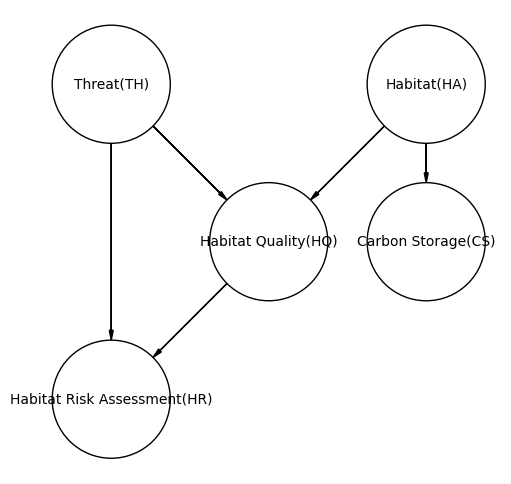

In [2]:
pgm_habitat=daft.PGM(grid_unit=4.0, node_unit=3)

pgm_habitat.add_node(daft.Node('HA', r"Habitat(HA)", 3, 3))
pgm_habitat.add_node(daft.Node('TH', r"Threat(TH)", 1, 3))
pgm_habitat.add_node(daft.Node('CS', r"Carbon Storage(CS)", 3, 2))
pgm_habitat.add_node(daft.Node('HQ', r"Habitat Quality(HQ)", 2, 2))
pgm_habitat.add_node(daft.Node('HR', r"Habitat Risk Assessment(HR)", 1, 1))

pgm_habitat.add_edge('TH','HQ')
pgm_habitat.add_edge('HA','HQ')
pgm_habitat.add_edge('HA','CS')
pgm_habitat.add_edge('TH','HR')
pgm_habitat.add_edge('HQ','HR')

pgm_habitat.render();

#### 2）因子分解

一般来讲，BN 中的每一个随机变量$X$都关联着一个 CPD，在已知其父节点每种可能状态的条件下，用来指明$X$状态的一个分布，记为$P(node \mid Par(node))$，式中，$Par(node)$为图中节点$node$的父节点，例如随机变量$HQ$依赖于$TH$和$HA$，其 CPD 表示为$P(HQ \mid TH,HA)$，对应着一个条件分布律（表）为变量`cpd_hq_sn`。对没有父节点的节点，例如$TH$和$HA$，其CPD以空集$Ø$为条件，实际上即为边缘分布$P(TH)$和$P(HA)$。对应各随机变量节点的 CPDs 图如下：

<img src="../imgs/3_5_b/3_5_b_01.jpg" height='auto' width=800 title="caDesign"> 

对于上述 BN（PGM）所有随机变量（属性、特征）的联合概率分布，考虑到随机变量之间的相互独立性，可以得到$P(TH,HA,HQ,CS,HR)=P(TH)P(HA)P(HQ \mid TH,HA)P(CS \mid HA)P(HR \mid TH,HQ)$，即对于 BN 的随机变量$\{X_1,X_2,\cdots,X_n\}$有联合概率分布$P\left(X_1, X_2, \ldots, X_n\right)=\prod_{i=1}^n P\left(X_i \mid \operatorname{Par}\left(X_i\right)\right)$，该公式为**贝叶斯网的链式法则**。可以表述为基于随机变量的独立性假设，PGM 分布$P$根据图$G$的因子分解（factorization），对应公式为$P\left(X_1, X_2, \ldots, X_n\right)=\prod_{i=1}^n P\left(X_i \mid \operatorname{Par}_G\left(X_i\right)\right)$。

* 定义参数：条件概率分布

使用`pgmpy`库的`TabularCPD`方法建立随机变量的 CPDs。

In [3]:
cpd_ha_sn=TabularCPD(variable='HA', variable_card=2, values=[[0.6], [0.4]], state_names={'HA': ['suitable', 'not suitable']})
cpd_th_sn=TabularCPD(variable='TH', variable_card=3, values=[[0.5], [0.3],[0.2]], state_names={'TH': ['strong', 'moderate','weak']})

cpd_cs_sn=TabularCPD(variable='CS', variable_card=3, 
                      values=[[0.7,0.3],
                              [0.2,0.3],
                              [0.1,0.4]],
                      evidence=['HA'],
                      evidence_card=[2],
                      state_names={'CS': ['rich', 'average','poor'],
                                   'HA':  ['suitable', 'not suitable']})

cpd_hq_sn=TabularCPD(variable='HQ', variable_card=2, 
                      values=[[0.2,0.4,0.9,0.3,0.3,0.4],
                              [0.8,0.6,0.1,0.7,0.7,0.6]],
                      evidence=['HA', 'TH'],
                      evidence_card=[2, 3],
                      state_names={'HQ': ['good', 'bad'],
                                   'HA': ['suitable', 'not suitable'],
                                   'TH': ['strong', 'moderate','weak']})
cpd_hr_sn=TabularCPD(variable='HR', variable_card=2,
                      values=[[0.9,0.6,0.6,0.5,0.4,0.1],
                              [0.1,0.4,0.4,0.5,0.6,0.9]],
                      evidence=['TH','HQ'],
                      evidence_card=[3,2],
                      state_names={'HR': ['high', 'low'],                                   
                                   'TH': ['strong', 'moderate','weak'],
                                   'HQ': ['good', 'bad']}) 


print(f'# Habitat\n{cpd_ha_sn}')
print(f'# Threat\n{cpd_th_sn}')
print(f'# Carbon Storage\n{cpd_cs_sn}')
print(f'# Habitat Quality\n{cpd_hq_sn}')
print(f'# Habitat Risk Assessment\n{cpd_hr_sn}')

# Habitat
+------------------+-----+
| HA(suitable)     | 0.6 |
+------------------+-----+
| HA(not suitable) | 0.4 |
+------------------+-----+
# Threat
+--------------+-----+
| TH(strong)   | 0.5 |
+--------------+-----+
| TH(moderate) | 0.3 |
+--------------+-----+
| TH(weak)     | 0.2 |
+--------------+-----+
# Carbon Storage
+-------------+--------------+------------------+
| HA          | HA(suitable) | HA(not suitable) |
+-------------+--------------+------------------+
| CS(rich)    | 0.7          | 0.3              |
+-------------+--------------+------------------+
| CS(average) | 0.2          | 0.3              |
+-------------+--------------+------------------+
| CS(poor)    | 0.1          | 0.4              |
+-------------+--------------+------------------+
# Habitat Quality
+----------+--------------+--------------+-----+------------------+------------------+
| HA       | HA(suitable) | HA(suitable) | ... | HA(not suitable) | HA(not suitable) |
+----------+--------------

* 链接图和条件概率分布

转化`daft`库构建的图为`pgmpy`库的形式，并将`pgmpy`库建立的 CPDs 链接到该图上，完成 BN（PGM）的构建。可以通过`check_mode`方法检验构建的 PGM 是否正确，如果提示随机变量的边缘分布不为1等情况，则需要对假设的概率数值进行调整，直至检查返回`True`，表明构建的 PGM 成立。

In [4]:
bn_habitat=usda_pgm.convert_pgm_to_pgmpy(pgm_habitat)
bn_habitat.add_cpds(cpd_ha_sn,cpd_th_sn,cpd_cs_sn,cpd_hq_sn,cpd_hr_sn)
bn_habitat.check_model()

True

建立 PGM 后可以读取计算相关信息，例如随机变量的 CPDs，状态基数等。

In [10]:
print(bn_habitat.get_cpds())
print(bn_habitat.get_cpds('HA'))
print(bn_habitat.get_cardinality('TH'))

[<TabularCPD representing P(HA:2) at 0x10bcceb5970>, <TabularCPD representing P(TH:3) at 0x10bf64e1a30>, <TabularCPD representing P(CS:3 | HA:2) at 0x10bcceb59a0>, <TabularCPD representing P(HQ:2 | HA:2, TH:3) at 0x10bf64e1d00>, <TabularCPD representing P(HR:2 | TH:3, HQ:2) at 0x10bcceb5a00>]
+------------------+-----+
| HA(suitable)     | 0.6 |
+------------------+-----+
| HA(not suitable) | 0.4 |
+------------------+-----+
3


#### 3）图中的独立性

依赖性（Dependencies）和独立性（independencies）是分布的两个主要性质，对理解分布的特征非常重要，并可从根本上降低推断的计算成本。BN 网络结构隐含的独立性可以分为两类：

**局部独立性（Local Independencies）**：图中任何变量都独立于给定其父类的非后代，公式可写为$ (X \perp NonDesc(X) | Pa(X) $；

**全局独立性（Global Independencies）**：为讨论 BN 中的全局独立性，需要查看各种可能的网络结构，如下内容。

* D-分离（D-separation）

**直接连接（Direct connection）**：当任意图（网络结构）$G$的随机变量（节点）$X$和$Y$有边$X  \rightarrow  Y（E(G)=XY）$（如下图）时，不论图中其它随机变量的证据（ evidence）如何，都可以构建$X$和$Y$相互关联的分布。例如，生境威胁（$TH$）和生境风险（$HR$）为$TH \rightarrow HR$，如果增加威胁的程度（概率），例如为`strong（0.5）`，那么生境风险评估变高的概率也会增加。

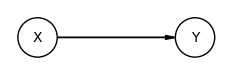

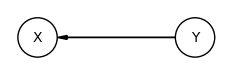

In [20]:
pgm_=daft.PGM()
pgm_.add_node(daft.Node('X', r"X", 1, 1))
pgm_.add_node(daft.Node('Y', r"Y", 3, 1))

pgm_xy=copy.deepcopy(pgm_)
pgm_xy.add_edge('X', 'Y')
pgm_xy.render();

#----------------------------------------------
pgm_yx=copy.deepcopy(pgm_)
pgm_yx.add_edge('Y', 'X')
pgm_yx.render();

在给定$TH$为状态`weak`和`strong`时，$HR$状态概率有相应变化。

In [88]:
infer_habitat=VariableElimination(bn_habitat)

print(infer_habitat.query(['HR'], evidence={'TH': 'weak'}))
print('/'*30)
print(infer_habitat.query(['HR'], evidence={'TH': 'strong'}))

+----------+-----------+
| HR       |   phi(HR) |
+==========+===========+
| HR(high) |    0.3100 |
+----------+-----------+
| HR(low)  |    0.6900 |
+----------+-----------+
//////////////////////////////
+----------+-----------+
| HR       |   phi(HR) |
+==========+===========+
| HR(high) |    0.6720 |
+----------+-----------+
| HR(low)  |    0.3280 |
+----------+-----------+


在给定$HR$为状态`high`和`low`时，$TH$状态概率也有相应变化。

In [87]:
print(infer_habitat.query(['TH'], evidence={'HR': 'high'}))
print('/'*30)
print(infer_habitat.query(['TH'], evidence={'HR': 'low'}))

+--------------+-----------+
| TH           |   phi(TH) |
+==============+===========+
| TH(strong)   |    0.6013 |
+--------------+-----------+
| TH(moderate) |    0.2878 |
+--------------+-----------+
| TH(weak)     |    0.1110 |
+--------------+-----------+
//////////////////////////////
+--------------+-----------+
| TH           |   phi(TH) |
+==============+===========+
| TH(strong)   |    0.3717 |
+--------------+-----------+
| TH(moderate) |    0.3155 |
+--------------+-----------+
| TH(weak)     |    0.3128 |
+--------------+-----------+


当图中一个影响（influence）能够沿迹（trail）从一个节点流动到另一个节点，称为有效迹（active trail），可以使用`is_dconnected`方法判断，例如，对于直接连接的$HR$和$TH$，其判断结果为`True`，为有效迹。

In [10]:
print(bn_habitat.is_dconnected('HR','TH'))
print(bn_habitat.is_dconnected('TH','HR'))

True
True


（补充）途径（Walk）、路（Paths）和迹（Trails）

图$G$中长度为$k$的**途径**是一个非空的顶点（节点）和边交错序列$v_0e_0v_1e_1 \cdots e_{k-1}v_k$，使得对于所有$i<k$均有$e_i=\{v_i,v_{i+1}\}$。若$v_0=v_k$，则称此途径是**闭合的（closed）**。如果途径中的顶点互不相同（除收尾顶点），则为$G$中的一条**路**；如果途径中的边互不相同，则为$G$中的一条**迹**。例如下图的哥尼斯堡七桥（Seven Bridges of Königsberg）中$B,e_1,A,e_2,C,e_6,D,e_7,B$为一个路，而$B,e_1,A,e_2,C,e_3,A,e_4,B$则为一个迹。

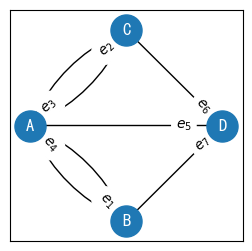

In [76]:
import networkx as nx
plt.figure(1,figsize=(3,3)) 

G = nx.DiGraph()
G.add_edge("A", "B", label='$e_1$')
G.add_edge("B", "A", label='$e_4$')
G.add_edge("A", "C", label='$e_2$')
G.add_edge("C", "A", label='$e_3$')
G.add_edge("A", "D", label='$e_5$')
G.add_edge("B", "D", label='$e_7$')
G.add_edge("C", "D", label='$e_6$')

positions = {"A": (0, 0), "B": (1, -2), "C": (1, 2), "D": (2, 0)}

edge_labels = nx.get_edge_attributes(G, "label")

nx.draw_networkx_nodes(G, pos=positions, node_size=500)
nx.draw_networkx_labels(G, pos=positions, font_color="w")
nx.draw_networkx_edges(
    G, pos=positions, edgelist=[("A", "D"), ("B", "D"), ("C", "D")], arrowstyle="-"
)
nx.draw_networkx_edges(
    G,
    pos=positions,
    edgelist=[("A", "B"), ("B", "A"), ("C", "A"), ("A", "C")],
    arrowstyle="-",
    connectionstyle="arc3,rad=0.2",
)
nx.draw_networkx_edge_labels(G, pos=positions, edge_labels=edge_labels, label_pos=0.2);

**间接连接（Indirect connection）**：如果$X$与$Y$不直接相连，但它们之间在图中存在一条迹，例如存在一条经过$Z$的迹，有如下4种情况，因果链（因果作用和证据作用），共同的原因和共同的租用。

1. 间接的因果作用（Indirect causal effect）（图 Causal）：以上述生境问题为例，对于迹$HA \rightarrow HQ \rightarrow HR$，如果观察到生境类型（$HA$）适合生物生存，为状态`suitable`，那么倾向于相信生境质量（$HQ$）状态`good`的概率会提高，生境风险（HR）的等级随之会相应提升，状态`high`的概率增加。即，后续事件的概率对于生境类型的观测值有较强的依赖，可以相信$X$通过$Z$可以作用于$Y$。但是，如果观察到$Z$，即观察到生境质量，那么生境类型不再对生境风险产生影响，为$HA \bot HR \mid HQ$，因此如果观察到$Z$，那么$X$不会通过$Z$作用于$Y$。

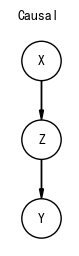

In [77]:
pgm_=daft.PGM()

pgm_.add_node(daft.Node('X', r"X", 1, 3))
pgm_.add_node(daft.Node('Z', r"Z", 1, 2))
pgm_.add_node(daft.Node('Y', r"Y", 1, 1))

#----------------------------------------------
pgm_causal=copy.deepcopy(pgm_)
pgm_causal.add_edge('X', 'Z')
pgm_causal.add_edge('Z', 'Y')
pgm_causal.add_text(0.7,3.5,label='Causal')
pgm_causal.render();

观测到$HA$状态为`suitable`，推断$HR$的概率。

In [103]:
print(infer_habitat.query(['HR'], evidence={'HA': 'suitable'}))

+----------+-----------+
| HR       |   phi(HR) |
+==========+===========+
| HR(high) |    0.5660 |
+----------+-----------+
| HR(low)  |    0.4340 |
+----------+-----------+


观测到$HQ$的状态为`bad`，推断$HR$的概率。

In [104]:
print(infer_habitat.query(['HR'], evidence={'HQ': 'bad'}))

+----------+-----------+
| HR       |   phi(HR) |
+==========+===========+
| HR(high) |    0.5222 |
+----------+-----------+
| HR(low)  |    0.4778 |
+----------+-----------+


2. 间接的证据作用（Indirect evidential effect）(图 Evidential)：仍然对于迹$HA \rightarrow HQ \rightarrow HR$，如果观察到$HR$状态为`high`，那么相信$HA$的`suitable`状态的概率会增加。同样，一旦观察到$HQ$，$HR$将不会对$HA$提高额外的信息。因此，对于情形$Y \rightarrow Z \rightarrow A$的分析与关于$X$可以通过$Z$来影响$Y$这一因果情形的分析一致，但仅限于没有观测到$Z$的情况。即$Y$可以通过$Z$为$X$提供额外的信息（影响$X$），但仅限于没有观测到$Z$的情形。因为独立性是一个对称的概念，因此如果$(X \bot Y)$不成立，那么$(Y \bot X)$也不成立。

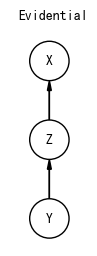

In [102]:
#----------------------------------------------
pgm_evidential=copy.deepcopy(pgm_)
pgm_evidential.add_edge('Y', 'Z')
pgm_evidential.add_edge('Z', 'X')
pgm_evidential.add_text(0.6,3.5,label='Evidential')
pgm_evidential.render();

观测到$HR$的状态为`high`，推断$HA$的概率。

In [105]:
print(infer_habitat.query(['HA'], evidence={'HR': 'high'}))

+------------------+-----------+
| HA               |   phi(HA) |
+==================+===========+
| HA(suitable)     |    0.6077 |
+------------------+-----------+
| HA(not suitable) |    0.3923 |
+------------------+-----------+


3. 共同的原因（Common cause）（图Common Cause）：以上述生境问题为例，对于迹$HQ \leftarrow HA \rightarrow CS$，生境类型$HA$是生境质量$HQ$和碳储存$CS$的父节点。$HQ$和$CS$在这个模型中相互关联，如果观察到生境质量较好，则提供了有关$HA$生境类型的信息，那么可以推测$HA$较为适合生物栖息，具有较好的生态系统，例如茂密的森林，进一步可以辅助推断碳储存的状态概率，趋向于较为丰富的碳储量。然而，一旦观察到$HA$，$HQ$和$CS$之间的关联就会消失，$HQ$不再提供有关$CS$的任何信息。即对于迹$X \leftarrow Z \rightarrow Y$，$X$可以通过$Z$影响$Y$，但仅限于没有观测到$Z$的情形。

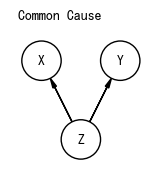

In [106]:
#----------------------------------------------
pgm_=daft.PGM()

pgm_.add_node(daft.Node('X', r"X", 1, 2))
pgm_.add_node(daft.Node('Z', r"Z", 1.5, 1))
pgm_.add_node(daft.Node('Y', r"Y", 2, 2))

pgm_common_cause=copy.deepcopy(pgm_)
pgm_common_cause.add_edge('Z', 'X')
pgm_common_cause.add_edge('Z', 'Y')
pgm_common_cause.add_text(0.7,2.5,label='Common Cause')
pgm_common_cause.render();

观测到$HQ$的状态为`good`，推断$CS$的概率。

In [108]:
print(infer_habitat.query(['CS'], evidence={'HQ': 'good'}))

+-------------+-----------+
| CS          |   phi(CS) |
+=============+===========+
| CS(rich)    |    0.5609 |
+-------------+-----------+
| CS(average) |    0.2348 |
+-------------+-----------+
| CS(poor)    |    0.2043 |
+-------------+-----------+


4. 共同的作用（Common effect ）(图Common Evidence)：对于上述3种情况，$X$可以通过$Z$来影响$Y$当且仅当没有观测到$Z$。但是，对于迹$X \rightarrow Z \leftarrow Y$，例如对于上述生境问题，有$TH \rightarrow HQ \leftarrow HA$，$TH$和$HA$都是$HQ$的父节点，当没有观测到$HQ$时，根据网络结构的局部独立性，$TH$和$HA$相互独立。因此，如果没有观测到$Z$，影响将无法沿着迹$X \rightarrow Z \leftarrow Y$流动。

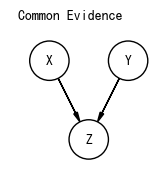

In [109]:
#----------------------------------------------
pgm_common_evidence=copy.deepcopy(pgm_)
pgm_common_evidence.add_edge('X', 'Z')
pgm_common_evidence.add_edge('Y', 'Z')
pgm_common_evidence.add_text(0.6,2.5,label='Common Evidence')
pgm_common_evidence.render();

通过`is_dconnected`方法得出$HA$和$TH$并不是有效迹，如果观测到$TH$状态为`strong`，可以发现$HA$的状态概率并没有发生变化；但是如果观测到$HQ$，可以发现此时$HA$和$TH$转变成有效迹，当同时观测到`HQ`的状态为`good`时，估计的$HA$状态概率发生了变化。

In [117]:
print(bn_habitat.is_dconnected('HA','TH'))
print(infer_habitat.query(['HA'], evidence={'TH':'strong'}))
print(bn_habitat.is_dconnected('HA','TH',observed='HQ'))
print(infer_habitat.query(['HA'], evidence={'TH':'strong','HQ': 'good'}))

False
+------------------+-----------+
| HA               |   phi(HA) |
+==================+===========+
| HA(suitable)     |    0.6000 |
+------------------+-----------+
| HA(not suitable) |    0.4000 |
+------------------+-----------+
True
+------------------+-----------+
| HA               |   phi(HA) |
+==================+===========+
| HA(suitable)     |    0.5000 |
+------------------+-----------+
| HA(not suitable) |    0.5000 |
+------------------+-----------+


当影响经过$Z$可以从$X$流向$Y$时，迹$X \rightleftharpoons Z \rightleftharpoons Y$是有效的（active）。对有效双边迹的分析结果总结如下：

* **因果迹**$X \rightarrow Z \rightarrow Y$：有效当且仅当没有观测到$Z$；
* **证据迹**$X \leftarrow Z \leftarrow Y$：有效当且仅当没有观测到$Z$；
* **共同的原因**$X \leftarrow Z \rightarrow Y$：有效当且仅当没有观测到$Z$；
* **共同的作用**$X \rightarrow Z \leftarrow Y$：有效当且仅当观察到$Z$或者$Z$的一个后代。形如$X \rightarrow Z \leftarrow Y$的结构称为一个**v-结构（v-structure）**。

将概率影响看作图中的流动非常有用，从上述网络结构可知，何时影响可以从$X$流经$Y$，然后影响到关于$Y$的置信度（beliefs）。

推演到一般情况，考虑迹比较长的情形，$X_1  \rightleftharpoons  \ldots   \rightleftharpoons X_n$。直观上，对于从$X_1$流动到$X_n$的影响，需要流经这条迹上的每个单元点。即，如果每条双边迹$X_{i-1}  \rightleftharpoons  X_i   \rightleftharpoons X_{i+1}$都允许影响流过，那么$X_1$可以影响到$X_n$。

定义：另$G$是一个贝叶斯网结构，且$X_1  \rightleftharpoons  \ldots   \rightleftharpoons X_n$是$G$中的一条迹。另$Z$是观测变量的一个子集，在给定$Z$的条件下，假如，

* 一旦有一个v-结构$X_{i-1} \rightarrow X_i \leftarrow X_{i+1}$，则$X_i$或其一个后代在$Z$中；
* 迹上的其它节点都不在$Z$中，

那么迹$X_1  \rightleftharpoons  \ldots   \rightleftharpoons X_n$是**有效迹**。

> 如果$X_1$或$X_n$在$Z$中，那么迹不是有效迹。

**d-分离（d-separation）** 提供在有向图节点之间分离的一个概念。

定义：令$\boldsymbol X,\boldsymbol Y,\boldsymbol Z$是图$G$的三个节点集。在给定$\boldsymbol Z$的条件下，加入任意节点$X \in \boldsymbol X$与$Y \in \boldsymbol Y$之间不存在有效迹，那么$\boldsymbol X$与$\boldsymbol Y$在给定$\boldsymbol Z$时是**d-分离**的，记作$d-sep_G(\boldsymbol X;\boldsymbol Y \mid \boldsymbol Z)$。与d-分离相对应的独立性的集合用$\mathcal{I}(\mathcal{G})$表示：$\mathcal{I}(\mathcal{G})=\left\{(X \perp Y \mid Z): \mathrm{d}-\operatorname{sep}_{\mathcal{G}}(\boldsymbol{X} ; \boldsymbol{Y} \mid \boldsymbol{Z})\right\}$。这个集合称为**全局马尔可夫独立性（global Markov independencies）**。

`local_independencies`方法返回随机变量的独立性实例，包含每个随机变量的局部独立性。例如下述结果中，给定$HA$时，$CS$和$TH,HQ,HR$相互独立。

In [120]:
rvs_habitat=['HA','TH','CS','HQ','HR']
print(bn_habitat.local_independencies(rvs_habitat))

(HA ⟂ TH)
(TH ⟂ CS, HA)
(CS ⟂ TH, HQ, HR | HA)
(HQ ⟂ CS | TH, HA)
(HR ⟂ CS, HA | TH, HQ)


`get_independencies`方法通过检查d-分离计算有向无环图（ Directed Acyclic Graph，DAG）中的独立性。

In [121]:
print(bn_habitat.get_independencies())

(TH ⟂ CS, HA)
(TH ⟂ HA | CS)
(TH ⟂ CS | HA)
(TH ⟂ CS | HR, HA)
(TH ⟂ CS | HQ, HA)
(TH ⟂ CS | HR, HQ, HA)
(HR ⟂ CS | HA)
(HR ⟂ CS, HA | TH, HQ)
(HR ⟂ CS | TH, HA)
(HR ⟂ CS | HQ, HA)
(HR ⟂ HA | TH, CS, HQ)
(HR ⟂ CS | TH, HQ, HA)
(HA ⟂ TH)
(HA ⟂ TH | CS)
(HA ⟂ HR | TH, HQ)
(HA ⟂ HR | TH, CS, HQ)
(CS ⟂ TH)
(CS ⟂ TH, HQ, HR | HA)
(CS ⟂ HR | TH, HQ)
(CS ⟂ HR, HQ | TH, HA)
(CS ⟂ TH, HR | HQ, HA)
(CS ⟂ TH, HQ | HR, HA)
(CS ⟂ HR | TH, HQ, HA)
(CS ⟂ HQ | TH, HA, HR)
(CS ⟂ TH | HR, HQ, HA)
(HQ ⟂ CS | HA)
(HQ ⟂ CS | TH, HA)
(HQ ⟂ CS | HR, HA)
(HQ ⟂ CS | TH, HA, HR)


对于网络结构中的任意两个变量$A$和$B$，如果$A$的任何变化影响$B$的值，那么说$A$和$B$之间存在有效迹。`pgmpy`库提供的`active_trail_nodes`方法，根据提供的节点返回一组受该节点变化影响的节点集合。例如，当未有观测到的节点状态时，$CS$的任何变化将会影响到$HQ,HA,HR$等节点；如果观测到$HA$，那么$CS$的任何变化将不会影响到其它任何网络结构中的节点。

In [127]:
print(bn_habitat.active_trail_nodes('CS'))
print(bn_habitat.active_trail_nodes('CS',observed='HA'))

{'CS': {'CS', 'HQ', 'HA', 'HR'}}
{'CS': {'CS'}}


### 3.5.2.2 推理

在阐述*图中的独立性*时，已经使用了`infer_habitat=VariableElimination(bn_habitat)`语句和`infer_habitat.query()`方法实现了相关推理，条件概率的概率查询（conditional probability query）$P(\boldsymbol{Y} \mid \boldsymbol{E}=\boldsymbol{e})$。条件概率查询适用于许多有用的推理模型，包括解释、预测、因果性推理等。根据条件概率的定义$P(\boldsymbol{Y} \mid \boldsymbol{E}=\boldsymbol{e})=\frac{P(\boldsymbol{Y}, \boldsymbol{e})}{P(\boldsymbol{e})}$，式中，分子的每个实例是一个概率表达式$P(y,e)$，可以通过对联合分布中的所有表值求和计算，这些表值对应于$y,e$的一致赋值。即，令$\boldsymbol{W}=\mathcal{X}-\boldsymbol{Y}-\boldsymbol{E} $为既不是查询（query）也不知证据（ evidence）的随机变量，那么$P(\boldsymbol{y}, \boldsymbol{e})=\sum_{\boldsymbol{w}} P(\boldsymbol{y}, \boldsymbol{e}, \boldsymbol{w})$。因为$\boldsymbol{Y},\boldsymbol{E},\boldsymbol{W}$是网络结构中所有随机变量，和式中的每一项$P(\boldsymbol{y}, \boldsymbol{e}, \boldsymbol{w})$为联合分布中的一个表值。概率$ P(\boldsymbol{e})$可以通过对联合分布求和直接计算，$P(\boldsymbol{e})=\sum_{\boldsymbol{y}} P(\boldsymbol{y}, \boldsymbol{e})$。

上述在给定联合分布时找到随机变量的条件分布计算中，会出现一个指数级的大表，并已证明，对于推理任务，指数爆炸（exponential blowup）问题在最坏情况下几乎肯定是不可避免地。然而在现实生活中，并不总是遇到最坏的情况，通过用于推理任务的的各种算法可以减小计算量，例如`pgmpy`库提供的`VariableElimination`变量消除算法，`BeliefPropagation`置信传播算法等。

下述事例使用 Daphne Koller 给出的学生示例模型<sup>[1]</sup>，结合`pgmpy`提供基于 Python 的推理算法，重述学生示例模型推理模式部分。

直接使用`pgmpy`构建 BN 模型，通过`to_daft`方法转化为`daft`库的图结构后打印查看图。该学生 BN 模型包含有5个随机变量，

1. 学生的智商（$I$），状态值有$Val(I)=\{Dumb, Intelligent\}$；
2. 课程的难度（$D$），状态值有$Val(D)=\{Easy, Hard\}$；
3. 考试的成绩（$G$），状态值有$Val(G)=\{A,B,C\}$；
4. 学生的SAT成绩（$S$）状态值有$Val(S)=\{Bad, Good\}$；
5. 推荐信的质量（$L$）状态值有$Val(L)=\{Bad, Good\}$。

In [4]:
model=BayesianNetwork([('D', 'G'), ('I', 'G'), ('G', 'L'), ('I', 'S')])

cpd_d_sn = TabularCPD(variable='D', variable_card=2, values=[[0.6], [0.4]], state_names={'D': ['Easy', 'Hard']})
cpd_i_sn = TabularCPD(variable='I', variable_card=2, values=[[0.7], [0.3]], state_names={'I': ['Dumb', 'Intelligent']})
cpd_g_sn = TabularCPD(variable='G', variable_card=3, 
                      values=[[0.3, 0.05, 0.9,  0.5],
                              [0.4, 0.25, 0.08, 0.3],
                              [0.3, 0.7,  0.02, 0.2]],
                      evidence=['I', 'D'],
                      evidence_card=[2, 2],
                      state_names={'G': ['A', 'B', 'C'],
                                   'I': ['Dumb', 'Intelligent'],
                                   'D': ['Easy', 'Hard']})

cpd_l_sn = TabularCPD(variable='L', variable_card=2, 
                      values=[[0.1, 0.4, 0.99],
                              [0.9, 0.6, 0.01]],
                      evidence=['G'],
                      evidence_card=[3],
                      state_names={'L': ['Bad', 'Good'],
                                   'G': ['A', 'B', 'C']})

cpd_s_sn = TabularCPD(variable='S', variable_card=2,
                      values=[[0.95, 0.2],
                              [0.05, 0.8]],
                      evidence=['I'],
                      evidence_card=[2],
                      state_names={'S': ['Bad', 'Good'],
                                   'I': ['Dumb', 'Intelligent']})

model.add_cpds(cpd_d_sn, cpd_i_sn, cpd_g_sn, cpd_l_sn, cpd_s_sn)
model.check_model()

True

转化为`daft`图结构，打印查看。

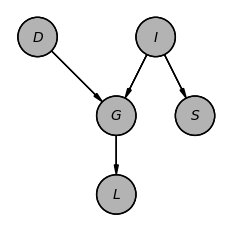

In [9]:
model_daft=model.to_daft(node_pos={'D':(1,3),'I':(2.5,3),'G':(2,2),'S':(3,2),'L':(2,1)})
model_daft.render(dpi=100);

将 CPDs 和图$G$的随机变量节点对应起来，方便查看。

<img src="../imgs/3_5_b/3_5_b_02.jpg" height='auto' width=800 title="caDesign"> 

在给定任意观测值$\boldsymbol{e}$时，联合分布$P_{\mathcal{B}}$具体指定了任意事件$\boldsymbol y$的概率$P_B(\boldsymbol{Y}=\boldsymbol{y} \mid \boldsymbol{E}=\boldsymbol{e})$：关于事件$\boldsymbol{E}=\boldsymbol{e}$，通过在联合分布上消除与观测$\boldsymbol{e}$不一致的表值，调节事件$\boldsymbol{E}=\boldsymbol{e}$的联合分布，并将结果表值重新归一化，使其总和为1。事件$\boldsymbol y$的概率可以通过累加与$\boldsymbol y$一致的结果后验分布中的所有表值的概率得到。

例如以学生 George 为例，用上述模型对 George 推理。如果要询问 George 有多大可能从课程 Econ101 的教授那里获得一封好的推荐信$(l^{Good})$。在对 George 和 Econ101 其它情况一无所知的条件下，这一概率为$P_{\mathcal{B}^{student}}(l^{good}) \approx  0.502$。

In [15]:
infer_student=VariableElimination(model)
print(infer_student.query(['L']))

+---------+----------+
| L       |   phi(L) |
+=========+==========+
| L(Bad)  |   0.4977 |
+---------+----------+
| L(Good) |   0.5023 |
+---------+----------+


现在了解到 George 不太聪明$(i^{Dumb})$，他从教课程 Econ101 的教授那里获得一封好的推荐信的概率降至到大约$P_{\mathcal{B}^{student}}(l^{good} \mid i^{Dumb}) \approx  0.389$。

In [142]:
print(infer_student.query(['L'],evidence={'I':'Dumb'}))

+---------+----------+
| L       |   phi(L) |
+=========+==========+
| L(Bad)  |   0.6114 |
+---------+----------+
| L(Good) |   0.3886 |
+---------+----------+


进一步得知 Econ101 是一门简单的课程$(d^{Easy})$，此时 George 从教授那里获得一封好的推荐信的概率为$P_{\mathcal{B}^{student}}(l^{good} \mid i^{Dumb},d^{Easy}) \approx  0.513$。这类可以预测已知各种因素（例如， George的智商）对“下游”的影响实例，为**因果推理（causal reasoning）或预测（prediction）**。

In [143]:
print(infer_student.query(['L'],evidence={'I':'Dumb','D':'Easy'}))

+---------+----------+
| L       |   phi(L) |
+=========+==========+
| L(Bad)  |   0.4870 |
+---------+----------+
| L(Good) |   0.5130 |
+---------+----------+


现在考虑 Acme 咨询公司的一个招聘官，他试图根据前面的模型决定是否雇佣 George。先验知识是，招聘官相信 George 有0.3的可能性为高智商。他有 George 特定课程 Econ101 的成绩记录并看到 George 的成绩为$(g^{C})$，此时，George 有高智商的概率突然降至约$P_{\mathcal{B}^{student}}(l^{good} \mid g^{C}) \approx  0.079$。

In [145]:
print(infer_student.query(['I'],evidence={'G':'C'}))

+----------------+----------+
| I              |   phi(I) |
+================+==========+
| I(Dumb)        |   0.9211 |
+----------------+----------+
| I(Intelligent) |   0.0789 |
+----------------+----------+


注意到此时课程难度的概率也从0.4上升为0.629。

In [146]:
print(infer_student.query(['D'],evidence={'G':'C'}))

+---------+----------+
| D       |   phi(D) |
+=========+==========+
| D(Easy) |   0.3707 |
+---------+----------+
| D(Hard) |   0.6293 |
+---------+----------+


现在假定招聘官丢失了 George 的成绩单，关于 George 的信息只剩下来自 Econ101 课程教授的推荐信，不过这封推荐信不是一封好的推荐信，此时，George 有高智商的概率依然会降低，为$P_{\mathcal{B}^{student}}(l^{good} \mid l^{Bad}) \approx  0.14$。

In [147]:
print(infer_student.query(['I'],evidence={'L':'Bad'}))

+----------------+----------+
| I              |   phi(I) |
+================+==========+
| I(Dumb)        |   0.8600 |
+----------------+----------+
| I(Intelligent) |   0.1400 |
+----------------+----------+


注意到，如果招聘官既有成绩单又有推荐信，George 有高智商的概率和只有成绩单时的概率一样，$P_{\mathcal{B}^{student}}(l^{good} \mid g^{C},l^{Bad}) \approx  0.079$。这类从结果推理原因的查询，是**证据推理（evidential reasoning）或解释（ explanation）**。

In [148]:
print(infer_student.query(['I'],evidence={'L':'Bad','G':'C'}))

+----------------+----------+
| I              |   phi(I) |
+================+==========+
| I(Dumb)        |   0.9211 |
+----------------+----------+
| I(Intelligent) |   0.0789 |
+----------------+----------+


最后，George 向招聘官提交了他的 SAT 成绩，令人惊讶的是，他的 SAT 成绩很高。George 有高智商的概率戏剧性的从0.079直线上升至$P_{\mathcal{B}^{student}}(l^{good} \mid g^{C},l^{Bad},S^{Good}) \approx  0.578$。

In [149]:
print(infer_student.query(['I'],evidence={'L':'Bad','G':'C','S':'Good'}))

+----------------+----------+
| I              |   phi(I) |
+================+==========+
| I(Dumb)        |   0.4217 |
+----------------+----------+
| I(Intelligent) |   0.5783 |
+----------------+----------+


直观上，与不好的考试成绩相比，SAT 高分更有价值的原因是低智商的学生 SAT 考试中获得高分的可能性非常低；相反，高智商的学生仍然可能获得$C$。而聪明的学生在难度高的课程中也更有可能获得$C$。事实上，可以看到，Econ101 是一门有难度的课程的概率已经从之前的0.629提高到了现在的$P_{\mathcal{B}^{student}}(D_{Hard} \mid g^{C},l^{Bad},S^{Good}) \approx  0.76$。

实际上，关于成绩$G$的变量，存在有一个因果因素，智商$I$为另一个变量课程难度$D$提供了信息。

In [16]:
print(infer_student.query(['D'],evidence={'L':'Bad','G':'C','S':'Good'}))

+---------+----------+
| D       |   phi(D) |
+=========+==========+
| D(Easy) |   0.2404 |
+---------+----------+
| D(Hard) |   0.7596 |
+---------+----------+


一方面，$P_{\mathcal{B}^{student}}(l^{good} \mid g^{C}) \approx  0.079$；另一方面，如果发现 Econ101 是一门难度高的课程，$P_{\mathcal{B}^{student}}(l^{good} \mid g^{C},d^{Hard}) \approx  0.11$。因此关于 George 在课程 Econ101 中的成绩，实际上给出部分解释。

In [156]:
print(infer_student.query(['I'],evidence={'G':'C','D':'Hard'}))

+----------------+----------+
| I              |   phi(I) |
+================+==========+
| I(Dumb)        |   0.8909 |
+----------------+----------+
| I(Intelligent) |   0.1091 |
+----------------+----------+


又如果，George 在课程 Econ101 中的成绩是$B$，则$P_{\mathcal{B}^{student}}(l^{good} \mid g^{B}) \approx  0.175$。

In [157]:
print(infer_student.query(['I'],evidence={'G':'B'}))

+----------------+----------+
| I              |   phi(I) |
+================+==========+
| I(Dumb)        |   0.8252 |
+----------------+----------+
| I(Intelligent) |   0.1748 |
+----------------+----------+


另一方面，如果 Econ101 比较难，那么$P_{\mathcal{B}^{student}}(l^{good} \mid g^{B},d^{Hard}) \approx  0.34$。实际上，已经通过课程的难度**解释消除（explained away）**了成绩低这一事件带来的影响。解释消除称为**因果间推理（ intercausal reasoning）**一般推理模式的一个示例。

In [158]:
print(infer_student.query(['I'],evidence={'G':'B','D':'Hard'}))

+----------------+----------+
| I              |   phi(I) |
+================+==========+
| I(Dumb)        |   0.6604 |
+----------------+----------+
| I(Intelligent) |   0.3396 |
+----------------+----------+


`query`方法返回为变量状态概率，而`map_query`方法直接返回具有最大概率的状态。例如下述条件概率查询有$P(I^{Intelligent})=0.892$，因此返回变量$I$的状态为$Intelligent$。

In [24]:
print(infer_student.map_query(['I'],evidence={'G':'B','D':'Hard','S':'Good'}))
print(infer_student.query(['I'],evidence={'G':'B','D':'Hard','S':'Good'}))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'I': 'Intelligent'}
+----------------+----------+
| I              |   phi(I) |
+================+==========+
| I(Dumb)        |   0.1084 |
+----------------+----------+
| I(Intelligent) |   0.8916 |
+----------------+----------+


## 3.5.3  连续型贝叶斯网络

许多情形下，需要在某个连续空间中取值，例如位置、温度、压力及气体浓度等，显然，这些情况都无法用表的形式来表示。一种解决策略是离散所有的连续变量，不过，为了得到合理准确的模型，通常需要非常精细的离散化操作，这使得变量的离散值数量庞大；且离散化连续变量常常会丢失许多刻画其特征的结构，例如连续变量“邻近的”离散值相关联概率之间成立的某种关系等。实际上，贝叶斯网络的简洁表示并未限制随机变量只为离散型，其仅有的要求是对$Pa_X$的每一个赋值$pa_X$，有$CPD \ P(X \mid Pa_X)$表示$X$上的一个分布，$X$可以是连续的，但 CPD 需要在值的一个连续统（ continuum）上表示分布；可能还存在$X$的一些连续的父节点，所以 CPD 还需要表示不同概率分布的一个连续统。

> 或描述为，对于随机变量$X$的 CPD，每一赋值$y_1 \in Val(Y_1), y_2 \in Val(Y_2), \cdots, y_n \in val(Y_n)$，有$P(X | Y_1, Y_2, \cdots Y_n)$表示$X$上的一个分布。

### 3.5.3.1 连续型随机变量的表示——`ContinuousFactor`方法

`pgmpy`库提供了`ContinuousFactor`方法来表征连续型随机变量$X$的分布，输入参数`variables`为定义分布的变量；`pdf`为分布的概率密度函数。

In [3]:
%load_ext autoreload 
%autoreload 2 
import usda.data_visual as usda_vis
import usda.pgm as usda_pgm

import numpy as np
from scipy.special import beta
from scipy.stats import multivariate_normal
from pgmpy.factors.continuous import ContinuousFactor
from pgmpy.factors.distributions import GaussianDistribution as JGD
from pgmpy.factors.continuous import CanonicalDistribution
from pgmpy.factors.continuous import LinearGaussianCPD
from pgmpy.models import LinearGaussianBayesianNetwork

import matplotlib.pyplot as plt
import matplotlib as mpl

In [1]:
from datascience import *
from prob140 import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight')

In [4]:
help(ContinuousFactor.__init__)

Help on function __init__ in module pgmpy.factors.continuous.ContinuousFactor:

__init__(self, variables, pdf, *args, **kwargs)
    Parameters
    ----------
    variables: list or array-like
        The variables for which the distribution is defined.
    
    pdf: function
        The probability density function of the distribution.
    
    Examples
    --------
    >>> import numpy as np
    >>> from scipy.special import beta
    >>> from pgmpy.factors.continuous import ContinuousFactor
    # Two variable dirichlet distribution with alpha = (1,2)
    >>> def dirichlet_pdf(x, y):
    ...     return (np.power(x, 1) * np.power(y, 2)) / beta(x, y)
    >>> dirichlet_factor = ContinuousFactor(['x', 'y'], dirichlet_pdf)
    >>> dirichlet_factor.scope()
    ['x', 'y']
    >>> dirichlet_factor.assignment(5,6)
    226800.0



* 示例分布-1

定义 pdf 为函数`drichlet_pdf`，包含2个变量$X,Y$，并打印查看分布图形。

In [4]:
def drichlet_pdf(x, y):
     return (np.power(x, 1)*np.power(y, 2))/beta(x, y)
    
Plot_3d(x_limits=(0,1), y_limits=(0,1), f=drichlet_pdf, cstride=4, rstride=4,interactive=True)  

interactive(children=(FloatSlider(value=20.0, description='elevation', max=90.0, step=1.0), FloatSlider(value=…

使用`ContinuousFactor`方法表征分布。可以通过`assignment`方式传入变量取值计算概率。

In [5]:
drichlet_factor = ContinuousFactor(['x', 'y'], drichlet_pdf) 
print(drichlet_factor.scope(),drichlet_factor.assignment(0.9,0.9),drichlet_factor.assignment(0.1,0.1))

['x', 'y'] 0.594569360493 5.0723727439e-05


* 示例分布-2

使用`reduce`方式可以指定待消减的随机变量一个值后，消减该变量。例如对含有3个变量的分布$y$指定0.8值消减后，转变为仅含有$x,z$的2个变量的分布。

In [6]:
def custom_pdf(x, y, z):
    return z*(np.power(x, 1)*np.power(y, 2))/beta(x, y)

custom_factor = ContinuousFactor(['x', 'y', 'z'], custom_pdf)
print(custom_factor.scope(),custom_factor.assignment(0.8, 0.8, 0.8)) 

['x', 'y', 'z'] 0.270012958213


In [7]:
custom_factor.reduce([('y', 0.8)])
print(custom_factor.scope(),custom_factor.assignment(0.8,0.8)) 

['x', 'z'] 0.270012958213


In [8]:
Plot_3d(x_limits=(0,1), y_limits=(0,1), f=custom_factor.pdf, cstride=4, rstride=4,interactive=True)  

interactive(children=(FloatSlider(value=20.0, description='elevation', max=90.0, step=1.0), FloatSlider(value=…

* 示例分布-3

使用`SciPy`库的`multivariate_normal`方法建立多个随机变量的多元正态分布，输入参数`mean`为分布的均值；`cov`为对称正定（半正定）协方差矩阵（Symmetric positive (semi)definite covariance matrix）。

> 关于*正定（半正定）协方差矩阵*参考本章最后部分。

In [10]:
help(multivariate_normal.pdf)

Help on method pdf in module scipy.stats._multivariate:

pdf(x, mean=None, cov=1, allow_singular=False) method of scipy.stats._multivariate.multivariate_normal_gen instance
    Multivariate normal probability density function.
    
    Parameters
    ----------
    x : array_like
        Quantiles, with the last axis of `x` denoting the components.
    mean : array_like, default: ``[0]``
        Mean of the distribution.
    cov : array_like, default: ``[1]``
        Symmetric positive (semi)definite covariance matrix of the distribution.
    allow_singular : bool, default: ``False``
        Whether to allow a singular covariance matrix.
    
    Returns
    -------
    pdf : ndarray or scalar
        Probability density function evaluated at `x`
    
    Notes
    -----
    Setting the parameter `mean` to `None` is equivalent to having `mean`
    be the zero-vector. The parameter `cov` can be a scalar, in which case
    the covariance matrix is the identity times that value, a vector 

In [9]:
std_normal_pdf = lambda *x: multivariate_normal.pdf(x, [0, 0], [[1, 0], [0, 1]])
std_normal = ContinuousFactor(['x1', 'x2'], std_normal_pdf)
print(std_normal.scope(),std_normal.assignment([0.5, 0.5]))

['x1', 'x2'] 0.12394999431


In [14]:
Plot_3d(x_limits=(-5,5), y_limits=(-5,5), f=std_normal.pdf, cstride=4, rstride=4,interactive=True)  

interactive(children=(FloatSlider(value=20.0, description='elevation', max=90.0, step=1.0), FloatSlider(value=…

In [15]:
Plot_3d(x_limits=(-5,5), y_limits=(-5,5), f=std_normal.pdf, cstride=4, rstride=4,interactive=True)  

interactive(children=(FloatSlider(value=20.0, description='elevation', max=90.0, step=1.0), FloatSlider(value=…

计算服从正态分布的二维随机变量$(X1,X2)$中关于$X2$的边缘概率分布。

In [65]:
std_normal.marginalize(['x2'])
print(std_normal.scope(), std_normal.assignment(0.5))

['x1'] 0.35206532676429947


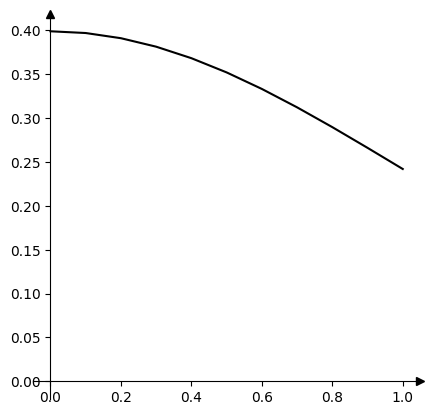

In [84]:
mpl.rcParams.update(mpl.rcParamsDefault)
fig, ax=plt.subplots(1, 1,figsize=(5,5))
x=np.arange(0,1+0.1,0.1)

ax.plot(x, list(map(std_normal.pdf,x)), 'k-', ms=8)
usda_vis.plot_style_axis_A(ax)
plt.show()

* 示例分布-4

`ContinuousFactor`类含有对分布执行乘除等计算。

In [11]:
sn_pdf1 = lambda x: multivariate_normal.pdf([x], [0], [[1]])
sn_pdf2 = lambda x1,x2: multivariate_normal.pdf([x1, x2], [0, 0], [[1, 0], [0, 1]])
sn1 = ContinuousFactor(['x2'], sn_pdf1)
sn2 = ContinuousFactor(['x1', 'x2'], sn_pdf2)
sn3 = sn1 * sn2
sn4 = sn2 / sn1
print(sn3.scope(),sn3.assignment(0.6, 0.6))
print(sn4.scope(), sn4.assignment(0.6, 0.6))

['x2', 'x1'] 0.0370008053775
['x1', 'x2'] 0.333224602892


In [12]:
Plot_3d(x_limits=(-3,3), y_limits=(-3,3), f=sn3.pdf, cstride=4, rstride=4,interactive=True) 

interactive(children=(FloatSlider(value=20.0, description='elevation', max=90.0, step=1.0), FloatSlider(value=…

In [13]:
Plot_3d(x_limits=(-3,3), y_limits=(-3,3), f=sn4.pdf, cstride=4, rstride=4,interactive=True) 

interactive(children=(FloatSlider(value=20.0, description='elevation', max=90.0, step=1.0), FloatSlider(value=…

### 3.5.3.2 多元高斯分布和CPD

#### 1）多元高斯分布

连续型变量的参数化空间在本质上是无界的，其中多元高斯分布类是简单的一种分布子类，具有很强的假设，例如分布偏离其均值的指数式衰减，及变量之间线性的交互作用等。在*概率论基础*部分阐述了一维和二维正态（高斯）分布，前文的示例分布3和4也使用`SciPy`库提供的方法建立二元和多元高斯分布。根据均值和方差这两个参数定义单变量高斯分布，对多个随机变量$X_1, \cdots, X_n$的多元高斯分布，则由$n$维的均值向量（ mean vector）$\mu$，及$n \times n$对称协方差矩阵（covariance matrix）$\sum$定义，密度函数定义如下：$p(x)=\frac{1}{(2 \pi)^{n / 2}|\Sigma|^{1 / 2}} \exp \left[-\frac{1}{2}(x-\mu)^{\mathrm{T}} \Sigma^{-1}(x-\mu)\right]$，式中$\mid \sum \mid$是$\sum$的行列式。


把标准高斯分布的概念推广到多维情况，将其定义为一个均值向量为0，协方差矩阵为对角线元素是1，其余元素是0的单位矩阵$I$的高斯分布。多维标准高斯分布仅是每一维上独立标准高斯分布的乘积。为了使这个等式导出定义明确积分为1的密度函数，矩阵$\sum$必须是正定的：对于任意满足$x  \neq 0$的$x \in \boldsymbol{R}^n$（$n$列向量），有$x^{\top} \Sigma x>0$。由于正定矩阵是非奇异的，因此其行列式大于0，这与该定义的必要条件一致。将多元高斯分布推广为半正定协方差矩阵的情况：对于任意的$x \in \boldsymbol{R}^n$，有$x^{\top} \Sigma x \geqslant 0$，其允许一些应用中的协方差矩阵是奇异的。

例如考虑三个随机变量上的一个特殊联合分布$p(X_1,X_2,X_3)$，均值向量$\mu$和协方差矩阵$\sum$为：$$ \mu=\left(\begin{array}{r}1 \\-3 \\4\end{array}\right), \quad \Sigma=\left(\begin{array}{rrr}4 & 2 & -2 \\2 & 5 & -5 \\-2 & -5 & 8\end{array}\right)$$。使用`pgmpy`库提供的`GaussianDistribution`（`JGD`）方法实现。

In [16]:
cov=np.array([[4, 2, -2], 
              [2, 5, -5], 
              [-2, -5, 8]])
dis = JGD(['x1', 'x2', 'x3'], np.array([[1], [-3], [4]]),cov)
print(dis.variables)
print(dis.mean)
print(dis.covariance)
print(dis.pdf([0.5,0.5,0.5]))

['x1', 'x2', 'x3']
[[ 1.]
 [-3.]
 [ 4.]]
[[ 4.  2. -2.]
 [ 2.  5. -5.]
 [-2. -5.  8.]]
0.00153154445492


检查协方差矩阵是否是正定/半正定矩阵。

In [47]:
usda_pgm.covariance_test(cov,[0,1])

{'Positive Definite': True,
 'Positive Semi-Definite': True,
 'Symmetric': True,
 'Positive Determinant': True,
 'Eigen Values, Positivity': True}

同`ContinuousFactor`类，由`GaussianDistribution`定义的高斯分布同样也含有边缘（高斯）分布（marginalize）、消减（reduce）、标准化（normalize）、乘除（product and divide）等运算。

In [17]:
dis1 = JGD(['x1', 'x2', 'x3'], np.array([[1], [-3], [4]]),np.array([[4, 2, -2], [2, 5, -5], [-2, -5, 8]]))
dis2 = JGD(['x3', 'x4'], [0, 2], [[1, 0], [0, 1]])
dis3 = dis1 * dis2
print(dis3.variables)
print(dis3.mean)
print(dis3.covariance)

['x1', 'x2', 'x3', 'x4']
[[ 1.88888889]
 [-0.77777778]
 [ 0.44444444]
 [ 2.        ]]
[[ 3.55555556  0.88888889 -0.22222222  0.        ]
 [ 0.88888889  2.22222222 -0.55555556  0.        ]
 [-0.22222222 -0.55555556  0.88888889  0.        ]
 [ 0.          0.          0.          1.        ]]


In [18]:
dis2.normalize(inplace=True)
Plot_3d(x_limits=(-5,5), y_limits=(-5,5), f=dis2.pdf, cstride=4, rstride=4,interactive=True) 

interactive(children=(FloatSlider(value=20.0, description='elevation', max=90.0, step=1.0), FloatSlider(value=…

#### 2）高斯密度的信息形式和`CanonicalDistribution`

由于正定矩阵是可逆的，如果高斯分布根据协方差矩阵的逆矩阵$J=\Sigma^{-1}$定义，$J$称为**信息矩阵**（information matrix）或**精度矩阵**（ precision matrix）。这种表示可以为高斯密度导出另一种形式，上述密度函数的指数有：$-\frac{1}{2}(x-\mu)^{\mathrm{T}} \Sigma^{-1}(x-\mu)=-\frac{1}{2}(x-\mu)^{\mathrm{T}} J(x-\mu) \\ =-\frac{1}{2}\left[x^{\mathrm{\top}} J x-2 x^{\mathrm{T}} J \mu+\mu^{\mathrm{\top}} J \mu\right]$，式中最后一项是常数，所以，$p(x) \propto \exp \left[-\frac{1}{2} \boldsymbol{x}^{\top} J \boldsymbol{x}+(J \boldsymbol{\mu})^{\top} \boldsymbol{x}\right]$。该高斯密度公式通常称为**信息形式**（information form），并且向量$h=J \mu$称为**位势向量**（ potential vector）。因为$\sum$正定当且仅当$\Sigma^{-1}$正定，所以信息形式定义了一个有效的高斯密度，当且仅当信息矩阵对称且正定。

根据高斯密度的信息形式，`pgmpy`提供了`CanonicalDistribution`方法以信息形式表述高斯密度分布。其输入参数`K`即`J`，为协方差矩阵的逆矩阵；`h`即位势向量；`g`为常数。

In [82]:
help(CanonicalDistribution.__init__)

Help on function __init__ in module pgmpy.factors.distributions.CanonicalDistribution:

__init__(self, variables, K, h, g)
    Parameters
    ----------
    variables: list or array-like
    The variables for wich the distribution is defined.
    
    K: n x n, 2-d array-like
    
    h : n x 1, array-like
    
    g : int, float
    
    pdf: function
    The probability density function of the distribution.
    
    The terms K, h and g are defined parameters for canonical
    factors representation.
    
    Examples
    --------
    >>> from pgmpy.factors.continuous import CanonicalDistribution
    >>> phi = CanonicalDistribution(['X', 'Y'], np.array([[1, -1], [-1, 1]]),
                              np.array([[1], [-1]]), -3)
    >>> phi.variables
    ['X', 'Y']
    
    >>> phi.K
    array([[1, -1],
           [-1, 1]])
    
    >>> phi.h
    array([[1],
           [-1]])
    
    >>> phi.g
    -3



In [83]:
phi1 = CanonicalDistribution(['x1', 'x2', 'x3'],np.array([[1, -1, 0], [-1, 4, -2], [0, -2, 4]]),np.array([[1], [4], [-1]]), -2)
phi2 = CanonicalDistribution(['x1', 'x2'], np.array([[3, -2], [-2, 4]]),np.array([[5], [-1]]), 1)

phi3 = phi1 * phi2
print(phi3.variables,'\n---',phi3.h,'\n---',phi3.K,'\n---',phi3.g)      

['x1', 'x2', 'x3'] 
--- [[ 6.]
 [ 3.]
 [-1.]] 
--- [[ 4. -3.  0.]
 [-3.  8. -2.]
 [ 0. -2.  4.]] 
--- -1


用`to_joint_gaussian`方法可以将高斯密度的信息形式转换回一般定义形式。

In [109]:
phi = CanonicalDistribution(['x1', 'x2'], np.array([[3, -2], [-2, 4]]),np.array([[5], [-1]]), 1)
jgd = phi.to_joint_gaussian()
print(jgd.variables)
print(jgd.covariance)
print(jgd.mean)

['x1', 'x2']
[[ 0.5    0.25 ]
 [ 0.25   0.375]]
[[ 2.25 ]
 [ 0.875]]


#### 3）二元高斯分布参数的矩阵表示

二元高斯分布的均值向量和协方差矩阵分别对应正态分布的一阶矩和二阶矩，用矩阵的符号表示有，$\mu=E[X]$，$\Sigma=E\left[X X^{\top}\right]-E[X] E[X]^{\top}$。这种表示在单变量的层次上分解，有$\mu_i$是$X_i$的均值，$\sum_{i,i}$是$X_i$的方差，且$\sum_{i,j}=\sum_{j,i},i \neq j$是$X_i$和$X_j$之间的协方差：$\operatorname{Cov}\left[X_i ; X_j\right]=\boldsymbol{E}\left[X_i X_j\right]-\boldsymbol{E}\left[X_i\right] \boldsymbol{E}\left[X_j\right]$。

#### 4）高斯分布的独立性

对于多元高斯分布，独立性可以根据分布的参数直接确定。

定理：另$\boldsymbol{X}=X_1, \cdots, X_n $有联合正态分布$\mathcal{N}(\mu ; \Sigma)$，那么$X_i$和$X_j$相互独立，当且仅当$ \Sigma_{i, j}=0 $。

用信息矩阵方式表述。

定理：考虑高斯分布$p\left(X_1, \cdots, X_n\right)=\mathcal{N}(\mu ; \Sigma)$，且令$J=\Sigma^{-1}$为其信息矩阵，则$J_{i, j}=0$，当且仅当$p \mid=\left(X_i \perp X_j \mid \mathcal{X}-\left\{X_i, X_i\right\}\right.$。



#### 5）线性高斯模型和CPD

考虑连续变量$Y$关于连续型父节点$X$的依赖，可以把对$Y$的分布构建为其参数取决于$X$值的高斯模型，一般的方式是决定$Y$的均值是$X$的线性函数，且$Y$的方差不依赖于$X$，例如$p(Y \mid x)=\mathcal{N}(-2 x+0.9 ; 1)$。这类独立性称为线性高斯（Linear Gaussian）模型。

定义：另$Y$有连续型父节点$X_1,\cdots,X_k$的连续型变量，假如存在参数$\beta_0, \ldots , \beta_k $和$\sigma^2$，使得$P\left(Y \mid x_1, \cdots, x_k\right)=\mathcal{N}\left(\beta_0+\beta_1 x_1+\cdots+\beta_k x_k ; \sigma^2\right) $，则称$Y$有一个线性高斯模型。该模型可以用向量表示为$P(Y \mid x)=\mathcal{N}\left(\beta_0+\beta^{\top} \boldsymbol{x} ; \sigma^2\right) $。

用`LinearGaussianCPD`方法定义线性高斯模型（CPD）。

In [85]:
help(LinearGaussianCPD.__init__)

Help on function __init__ in module pgmpy.factors.continuous.LinearGaussianCPD:

__init__(self, variable, evidence_mean, evidence_variance, evidence=[], beta=None)
    Parameters
    ----------
    
    variable: any hashable python object
        The variable whose CPD is defined.
    
    evidence_mean: Mean vector (numpy array) of the joint distribution, X
    
    evidence_variance: int, float
        The variance of the multivariate gaussian, X = ['x1', 'x2', ..., 'xn']
    
    evidence: iterable of any hashable python objects
        An iterable of the parents of the variable. None if there are no parents.
    
    beta (optional): iterable of int or float
        An iterable representing the coefficient vector of the linear equation.
        The first term represents the constant term in the linear equation.
    
    
    Examples
    --------
    
    # For P(Y| X1, X2, X3) = N(-2x1 + 3x2 + 7x3 + 0.2; 9.6)
    
    >>> cpd = LinearGaussianCPD('Y',  [0.2, -2, 3, 7], 9.6, ['X1',

In [19]:
cpd = LinearGaussianCPD('Y',  [0.2, -2, 3, 7], 9.6, ['X1', 'X2', 'X3'])
print(cpd)

P(Y | X1, X2, X3) = N(-2*X1 + 3*X2 + 7*X3 + 0.2; 9.6)


In [20]:
Plot_3d(x_limits=(-25,25), y_limits=(0,1), f=cpd.pdf, cstride=4, rstride=4,interactive=True) 

interactive(children=(FloatSlider(value=20.0, description='elevation', max=90.0, step=1.0), FloatSlider(value=…

### 3.5.3.3 高斯贝叶斯网

基于线性高斯模型用贝叶斯网定义连续的联合分布。

定义：**高斯贝叶斯网**定义为其所有变量都是连续的，且其中的所有 CPD 都是线性高斯的贝叶斯网。

定理：令$Y$是其父节点$X_1,\cdots,X_k$的线性高斯$p(Y \mid \boldsymbol{x})=\mathcal{N}\left(\boldsymbol{\beta}_0+\boldsymbol{\beta}^{\top} \boldsymbol{x} ; \sigma^2\right)$，假设$X_1,\cdots,X_k$是具有分布$\mathcal{N}(\mu ; \Sigma) $的联合高斯，则：

* $Y$的分布是一个正态分布$p(Y)=\mathcal{N}\left(\mu_Y ; \sigma_Y^2\right)$，式中，$\mu_\gamma=\beta_0+\beta^{\mathrm{T}} \mu$；$ \sigma_Y^2=\sigma^2+\beta^{\top} \Sigma \beta$；

* $\{X,Y\}$上的联合分布是一个正态分布，其中$\operatorname{Cov}\left[X_i ; Y\right]=\sum_{j=1}^k \beta_j \Sigma_{i, j}$。

例如，对于线性高斯网$X_1 \rightarrow X_2 \rightarrow X_3$，有$p\left(X_1\right)=\mathcal{N}(1 ; 4) \\ p\left(X_2 \mid X_1\right)=\mathcal{N}\left(0.5 X_1-3.5 ; 4\right) \\ P\left(X_3 \mid X_2\right)=\mathcal{N}\left(-X_2+1 ; 3\right)$，根据上述定理，可以计算高斯分布$P\left(X_1, X_2, X_3\right)$。对于均值有，$ \mu_2=0.5 \mu_1-3.5=0.5 \cdot 1-3.5=-3 \\ \mu_3=(-1) \mu_2+1=(-1) \cdot(-3)+1=4$

$X_2$和$X_3$的方差计算为：$\Sigma_{22}=4+(1 / 2)^2 \cdot 4=5 \\ \Sigma_{33}=3+(-1)^2 \cdot 5=8$，可以看到变量的方差是两项和：源自自身高斯噪声（Gaussian noise）参数的方差和源自由依赖性强度加权其父节点变量的方差。协方差的计算结果如下：$\Sigma_{12}=(1 / 2) \cdot 4=2 \\ \Sigma_{23}=(-1) \cdot \Sigma_{22}=-5 \\ \Sigma_{13}=(-1) \cdot \Sigma_{12}=-2$

上述计算过程，可以由`pgmpy`库的`LinearGaussianBayesianNetwork`方法建立高斯贝叶斯网（高斯 BN），通过`to_joint_gaussian`方法得到联合高斯分布$ P\left(X_1, X_2, X_3\right)$后计算。

In [98]:
model = LinearGaussianBayesianNetwork([('x1', 'x2'), ('x2', 'x3')])
cpd1 = LinearGaussianCPD('x1', [1], 4)
cpd2 = LinearGaussianCPD('x2', [-3.5, 0.5], 4, ['x1'])
cpd3 = LinearGaussianCPD('x3', [1, -1], 3, ['x2'])

cpd1.variables = [*cpd1.evidence, cpd1.variable]
cpd2.variables = [*cpd2.evidence, cpd2.variable]
cpd3.variables = [*cpd3.evidence, cpd3.variable]
model.add_cpds(cpd1, cpd2, cpd3)
jgd = model.to_joint_gaussian()
print(jgd.variables)
print(jgd.mean)
print(jgd.covariance)

for i in model.cpds:
    print(i)

['x1', 'x2', 'x3']
[[ 1.]
 [-3.]
 [ 4.]]
[[ 4.  2. -2.]
 [ 2.  5. -5.]
 [-2. -5.  8.]]
P(x1) = N(1; 4)
P(x2 | x1) = N(0.5*x1 + -3.5; 4)
P(x3 | x2) = N(-1*x2 + 1; 3)


## 3.5.4 学习（Learning）

前文叙述的贝叶斯网络（BN）直接构建（含结构（图）和参数（CPD））后再进行推理分析的方式，实际上并不实用。原因是参数的配置（CPDs）由人工完成并不现实，一方面由各个领域专家参与相关模型的参数评估不容易实现，也会耗费过多的时间成本，且配置的参数需要通过不断的测试验证，其准确性不容易达到；另外，可能由于情况的变化，模型往往需要重新设计，这也为直接建立结构和参数的模型带来困难。然而由于数据的不断积累，从数据中学习模型的结构和参数成为可能，此类建立模型的方法称为**模型学习（model learning）**。

模型学习涉及两个方面：

1. 参数估计（Parameter Estimation）：给定一组数据样本和一个可以捕获变量之间依赖关系的 DAG，估计各个变量的（条件）概率分布（CPDs）。一般包括最大似然估计（Maximum Likelihood Estimation，MLE）和贝叶斯参数估计（Bayesian Parameter Estimation）等方法；
2. 结构学习（Structure Learning）：给定一组数据样本，估计一个可以捕获变量之间依赖关系的 DAG 及变量之间的（条件）概率分布。一般包括基于得分（Score-based）的结构估计，基于约束（Constrain-based）的结构估计（PC）和混合（Hybrid）结构估计（MMHC）。

### 3.5.4.1 参数估计<sup>[5,2,1]</sup>

数据集$\mathcal{X} \triangleq\left\{x_i\right\}_{i=1}^{|X|}$，为随机变量（random variable, r.v.）$X$的一系列独立同分布（independent and identically distribute，i.i.d）的实现。参数$\vartheta$依赖于所考虑的一个分布，例如，高斯分布$\vartheta \sim \operatorname{N}\left\{\mu, \sigma^2\right\}$等。对于这些数据（$\mathcal{X}$）和参数（$\vartheta$），根据贝叶斯公式：$P(A \mid B)=\frac{P(B \mid A) P(A)}{P(B)}$，式中，$A$和$B$为随机事件，且$P(B) \neq 0$：

* $P(A \mid B)$为条件概率（ conditional probability），在事件$B$发生条件下事件$A$发生的概率，也称为给定$B$事件下事件$A$的后验概率（posterior probability）；
* $P(B \mid A)$同为条件概率，在事件$A$发生条件下事件$B$发生的概率，因为$P(B \mid A)=L(A \mid B)$，也被解释为固定给定的$B$，对于$A$的似然（likelihood）；
* $P(A)$和$P(B)$是不给定任何条件下，观测到的事件$A$和$B$各自的概率，也称为先验概率（prior probability）和边缘概率（marginal probability）。

有$p(\vartheta \mid \mathcal{X})=\frac{p(\mathcal{X} \mid \vartheta) \cdot p(\vartheta)}{p(\mathcal{X})}$，因此用术语表述有：$\text { posterior }=\frac{\text { likelihood } \cdot \text { prior }}{\text { evidence }}$。

下述试验中，提供了两个案例，分布对应两组数据，一组来自于 Heinrich, G 论文不均匀硬币抛掷试验，`coin_data`，仅包含一个随机变量$tossing$，含两个状态，正面`head`用1表示，反面`tail`用0表示；另一组来自于`pgmpy`库说明文件中水果味道的数据，`fruit_data`，包含有3个随机变量$(fruit,size,tasty)$，每个随机变量各包含两个状态，分别为`banana,apple`，`large,small`和`yes,no`。

In [163]:
%load_ext autoreload 
%autoreload 2 
import usda.data_visual as usda_vis
import usda.pgm as usda_pgm

import daft
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination,BeliefPropagation
from pgmpy.estimators import ParameterEstimator,MaximumLikelihoodEstimator,BayesianEstimator

import pandas as pd
from scipy.stats import bernoulli,beta,binom
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn import preprocessing

import sympy
from sympy import Symbol, simplify, pprint, factor,solve,log
from sympy.stats import Beta, density, E, variance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
coin_data=pd.DataFrame(bernoulli.rvs(0.5, size=20),columns=['tossing'])
print(coin_data)

print('-'*50)
fruit_data = pd.DataFrame(data={'fruit': ["banana", "apple", "banana", "apple", "banana","apple", "banana", 
                                    "apple", "apple", "apple", "banana", "banana", "apple", "banana",], 
                          'tasty': ["yes", "no", "yes", "yes", "yes", "yes", "yes", 
                                    "yes", "yes", "yes", "yes", "no", "no", "no"], 
                          'size': ["large", "large", "large", "small", "large", "large", "large",
                                    "small", "large", "large", "large", "large", "small", "small"]})
print(fruit_data)

    tossing
0         1
1         1
2         0
3         0
4         1
5         0
6         0
7         1
8         1
9         1
10        1
11        0
12        1
13        1
14        1
15        0
16        0
17        1
18        0
19        1
--------------------------------------------------
     fruit tasty   size
0   banana   yes  large
1    apple    no  large
2   banana   yes  large
3    apple   yes  small
4   banana   yes  large
5    apple   yes  large
6   banana   yes  large
7    apple   yes  small
8    apple   yes  large
9    apple   yes  large
10  banana   yes  large
11  banana    no  large
12   apple    no  small
13  banana    no  small


#### 1）最大似然估计（MLE）

MLE 试图找到使得似然最大化的参数，有$L(\vartheta \mid \mathcal{X}) \triangleq p(\mathcal{X} \mid \vartheta)=\bigcap_{x \in \mathcal{X}}\{X=x \mid \vartheta\}=\prod_{x \in \mathcal{X}} p(x \mid \vartheta)$，即从随机变量$X$中观测到的事件数据集$\mathcal{X}$的联合概率。因为似然函数和似然函数的对数最大化（达到最大值）所对应的参数$\vartheta$相同（可以查看*2.6.2 逻辑回归二分类到 SoftMax 回归多分类*部分的图表），且与原始似然函数相比，似然函数的对数求导更容易，因此$\mathcal{L} \triangleq \log L$，MLE 可写为：$\hat{\vartheta}_{\mathrm{ML}}=\underset{\vartheta}{\operatorname{argmax}} \mathcal{L}(\vartheta \mid \mathcal{X})=\underset{\vartheta}{\operatorname{argmax}} \sum_{x \in \mathcal{X}} \log p(x \mid \vartheta)$。对参数估计就是对似然函数$L(\vartheta \mid \mathcal{X})$求导，有$ \frac{\partial \mathcal{L}(\vartheta \mid \mathcal{X})}{\partial \vartheta_k} \stackrel{!}{=} 0 \quad \forall \vartheta_k \in \vartheta$。

根据已知数据集$\mathcal{X}$估计参数后，可以预测一个新观测值$\tilde{x}$的概率，有$p(\tilde{x} \mid \mathcal{X})  =\int_{\vartheta \in \Theta} p(\tilde{x} \mid \vartheta) p(\vartheta \mid \mathcal{X}) \mathrm{d} \vartheta \\  \approx \int_{\vartheta \in \Theta} p\left(\tilde{x} \mid \hat{\vartheta}_{\mathrm{ML}}\right) p(\vartheta \mid \mathcal{X}) \mathrm{d} \vartheta=p\left(\tilde{x} \mid \hat{\vartheta}_{\mathrm{ML}}\right)$。

不均匀硬币抛掷试验（伯努利试验），估计未知参数$p$。由伯努利分布（伯努利密度函数），对于随机变量$C$有，$p(C=c \mid p)=p^c(1-p)^{1-c} \triangleq \operatorname{Bern}(c \mid p)$，式中，定义$c=1$为正面`head`，$c=0$为背面`tail`。对参数$p$构建 MLE，为数据$\mathcal{X}$的一个函数，有$\mathcal{L}=\log \prod_{i=1}^N p\left(C=c_i \mid p\right)=\sum_{i=1}^N \log p\left(C=c_i \mid p\right) \\ =n^{(1)} \log p(C=1 \mid p)+n^{(0)} \log p(C=0 \mid p) \\ =n^{(1)} \log p+n^{(0)} \log (1-p) $，式中，$n^{(c)} $为伯努利试验结果事件$c$，正面或背面的次数。对参数$p$微分得到，$\frac{\partial \mathcal{L}}{\partial p}=\frac{n^{(1)}}{p}-\frac{n^{(0)}}{1-p} \stackrel{!}{=} 0 \Leftrightarrow \quad \hat{p}_{\mathrm{ML}}=\frac{n^{(1)}}{n^{(1)}+n^{(0)}}=\frac{n^{(1)}}{N}$。

例如，对于数据集`coin_data`，通过直接计算频率，及应用`pgmpy`库分别计算，计算结果同，正面朝上的概率（参数）为0.598。

In [172]:
print(coin_data.value_counts(normalize =True))

coin_bn=BayesianNetwork()
coin_bn.add_node('tossing')
coin_bn.fit(coin_data, estimator=MaximumLikelihoodEstimator) # `BayesianNetwork`类内置的`fit`方法提供了参数估计方便的操作模式。
print(coin_bn.cpds[0])

tossing
1          0.6
0          0.4
dtype: float64
+------------+-----+
| tossing(0) | 0.4 |
+------------+-----+
| tossing(1) | 0.6 |
+------------+-----+


对于水果味道观测试验，定义贝叶斯网络（BN），含有3个随机变量（节点）$(fruit,tasty,size)$，有边$fruit \rightarrow tasty, size \rightarrow tasty$，为v-结构。且已知数据`data`，估计参数，即 CPDs。为了理解给定的数据，根据父节点$fruit,size$计算子节点$tasty$对应的数量，可知共有`apple`7个，`banana`7个，总共14个$fruit$；其中对于$fruit$状态`apple`，当$size$状态为`large`时，对于$tasty$状态为`yes`有3个，`no`的有1个，其它情况以此类推。

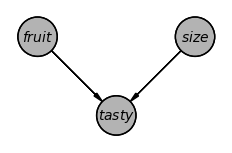

In [10]:
fruit_bn = BayesianNetwork([('fruit', 'tasty'), ('size', 'tasty')])
fruit_bn_daft=fruit_bn.to_daft(node_pos={'fruit':(1,2),'size':(3,2),'tasty':(2,1)})
fruit_bn_daft.render(dpi=100);

In [57]:
fruit_bn_pe=ParameterEstimator(fruit_bn, fruit_data)
print("\n", fruit_bn_pe.state_counts('fruit'))  # unconditional
print("\n", fruit_bn_pe.state_counts('tasty'))  # conditional on fruit and size


         fruit
apple       7
banana      7

 fruit apple       banana      
size  large small  large small
tasty                         
no      1.0   1.0    1.0   1.0
yes     3.0   2.0    5.0   0.0


用`MaximumLikelihoodEstimator`方法根据定义的图$G$结构和反映随机变量间关系的数据`fruit_data`，直接计算 BN 的 CPDs 如下。

In [58]:
fruit_bn_fitted = MaximumLikelihoodEstimator(fruit_bn, fruit_data)
print(fruit_bn_fitted.estimate_cpd('fruit')) 
print('/'*50)
for cpd in fruit_bn_fitted.get_parameters():
    print(cpd)

+---------------+-----+
| fruit(apple)  | 0.5 |
+---------------+-----+
| fruit(banana) | 0.5 |
+---------------+-----+
//////////////////////////////////////////////////
+---------------+-----+
| fruit(apple)  | 0.5 |
+---------------+-----+
| fruit(banana) | 0.5 |
+---------------+-----+
+------------+--------------+--------------------+---------------------+---------------+
| fruit      | fruit(apple) | fruit(apple)       | fruit(banana)       | fruit(banana) |
+------------+--------------+--------------------+---------------------+---------------+
| size       | size(large)  | size(small)        | size(large)         | size(small)   |
+------------+--------------+--------------------+---------------------+---------------+
| tasty(no)  | 0.25         | 0.3333333333333333 | 0.16666666666666666 | 1.0           |
+------------+--------------+--------------------+---------------------+---------------+
| tasty(yes) | 0.75         | 0.6666666666666666 | 0.8333333333333334  | 0.0          

#### 2）最大后验估计（Maximum a posteriori estimation，MAP(E)）

MAP 类似于 MLE，但允许通过使用先验分布（prior distribution）$p(\vartheta)$对参数进行加权，为给定数据$\mathcal{X}$条件下最大化参数后验的目标，$\hat{\vartheta}_{\mathrm{MAP}}=\underset{\vartheta}{\operatorname{argmax}} p(\vartheta \mid \mathcal{X})$。通过贝叶斯公式，有$\hat{\vartheta}_{\mathrm{MAP}}=\underset{\vartheta}{\operatorname{argmax}} \frac{p(\mathcal{X} \mid \vartheta) p(\vartheta)}{p(\mathcal{X})} \quad \mid p(\mathcal{X}) \neq f(\vartheta) \\ =\underset{\vartheta}{\operatorname{argmax}} p(\mathcal{X} \mid \vartheta) p(\vartheta)=\underset{\vartheta}{\operatorname{argmax}}\{\mathcal{L}(\vartheta \mid \mathcal{X})+\log p(\vartheta)\} \\ =\underset{\vartheta}{\operatorname{argmax}}\left\{\sum_{x \in \mathcal{X}} \log p(x \mid \vartheta)+\log p(\vartheta)\right\}$。

一个先验分布$p(\vartheta)$被加到似然项$p(x \mid \vartheta)$上，通过这额外的先验知识平衡数据集的观测结果，避免 MLE 这一简单模型的过拟合现象。对$p(\vartheta)$的数据建模延续贝叶斯方法，将$\vartheta$看作随机变量，有$ p(\vartheta):=p(\vartheta \mid \alpha) $，式中，$\alpha$为超参数（hyperparameters）。$p(\vartheta)$表达了对参数$\vartheta$预期值的一个信念（belief）。

MAP 通过最大化$\mathcal{L}(\vartheta \mid \mathcal{X})+\log p(\vartheta)$估计参数$\vartheta$。参数估计后，同 MLE，可以计算给定观测值$\tilde{x}$的概率，$p(\tilde{x} \mid X) \approx \int_{\vartheta \in \Theta} p\left(\tilde{x} \mid \hat{\vartheta}_{\mathrm{MAP}}\right) p(\vartheta \mid X) \mathrm{d} \vartheta=p\left(\tilde{x} \mid \hat{\vartheta}_{\mathrm{MAP}}\right)$，式中，$\Theta$为参数空间。

返回硬币抛掷试验。因为我们根据经验相信在抛掷硬币时，有0.5的几率为正面，0.5的几率为背面，选择 Beta 分布定义$\vartheta$的先验分布$p(\vartheta)$有，$p(p \mid \alpha, \beta)=\frac{1}{\mathrm{~B}(\alpha, \beta)} p^{\alpha-1}(1-p)^{\beta-1} \triangleq \operatorname{Beta}(p \mid \alpha, \beta)$，式中，$\mathrm{B}(\alpha, \beta)=\frac{\Gamma(\alpha) \Gamma(\beta)}{\Gamma(\alpha+\beta)}$。对于 Beta 的概率密度函数（PDF）可书写为：$f(x, a, b) = \frac{\Gamma(a+b) x^{a-1} (1-x)^{b-1}}{\Gamma(a) \Gamma(b)}, 0 \leq x  \leq 1,a>0,b>0$，式中，$\Gamma$为伽马函数（gamma function ），定义为，$\Gamma(z) = \int_0^\infty t^{z-1} e^{-t} dt,\Re(z)>0$。

使用`SciPy`库，给定不同的$a,b$值，打印观察 PDF 曲线。因为相信一半的几率正面朝上，因此配置超参数$\alpha = \beta=5$（对应$a,b$），其 PDF 曲线最大值位于0.5处，即预先相信正面朝上为0.5概率的可能性最大。最大值为0.5的 Beta 密度函数并不唯一，只要满足$a,b$值相同，其差异是曲线的强度（峰度）变化。一般而言，对于少量样本数据使用峰度偏小的分布曲线，而大量样本数据使用峰度偏大的分布曲线。

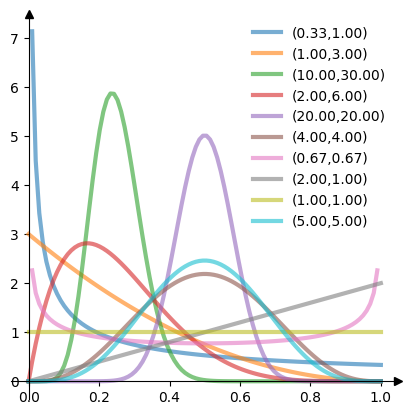

In [15]:
fig, ax=plt.subplots(1, 1,figsize=(5,5))

ab_lst=[(1/3,1),(1,3),(10,30),(2,6),(20,20),(4,4),(2/3,2/3),(2,1),(1,1),(5,5)]
x = np.linspace(0, 1, 100)

for a,b in ab_lst:
    ax.plot(x, beta.pdf(x, a, b), lw=3, alpha=0.6, label=f'({a:.2f},{b:.2f})')

usda_vis.plot_style_axis_A(ax)
plt.legend(loc='upper right',frameon=False)
plt.show()

推导增加所估计参数的先验分布后，找到 MAP 最大化的参数为，$\frac{\partial}{\partial p} \mathcal{L}+\log p(p)=\frac{n^{(1)}}{p}-\frac{n^{(0)}}{1-p}+\frac{\alpha-1}{p}-\frac{\beta-1}{1-p} \stackrel{!}{=} 0 \\ \Leftrightarrow \quad \hat{p}_{\mathrm{MAP}}=\frac{n^{(1)}+\alpha-1}{n^{(1)}+n^{(0)}+\alpha+\beta-2}=\frac{n^{(1)}+4}{n^{(1)}+n^{(0)}+8}$。依据该公式，MAP 参数估计的结果为0.571，相对于 MLE 的0.6结果，估计的参数受到先验信念（prior belief）的影响，趋向于$p(\vartheta)$分布最大值对应的$\vartheta$参数值（该试验中为0.5）。

In [227]:
head_num,tail_num=coin_data.value_counts()
print(head_num,tail_num)
tossing_map_theta=(head_num+4)/(head_num+tail_num+8)
print(tossing_map_theta)

12 8
0.5714285714285714


#### 3）贝叶斯参数估计（Bayesian Parameter Estimation，BPE）

贝叶斯参数估计（BPE）通过允许参数集$\vartheta$服从一定的的概率分布，而不是直接进行参数值估计来拓展 MAP 的方法。MLE 和 MAP 都求出了参数$\vartheta$的值，BPE 则根据参数的先验分布$p(\vartheta)$和观察到的随机变量数据集$\mathcal{X}$，求取参数$\vartheta$的后验分布$p(\vartheta \mid X)$，然后求出$\vartheta$的期望值作为最终值。同时定义了一个参数的方差量来评估参数估计的质量或置信度（conﬁdence）。依据贝叶斯公式计算后验分布有，$p(\vartheta \mid X)=\frac{p(\mathcal{X} \mid \vartheta) \cdot p(\vartheta)}{p(\mathcal{X})}$。因为并不求后验分布的最大化值，因此需要计算式中的$p(\mathcal{X})$项，由全概率公式展开可得$p(\mathcal{X})=\int_{\vartheta \in \Theta} p(\mathcal{X} \mid \vartheta) p(\vartheta) \mathrm{d} \vartheta$。当观测到新的数据$\tilde{x}$，后验概率$p(\vartheta \mid X)$自动随之调整。用 BPE 预测新观测到的数据$\tilde{x}$的概率，有$p(\tilde{x} \mid \mathcal{X})=\int_{\vartheta \in \Theta} p(\tilde{x} \mid \vartheta) p(\vartheta \mid \mathcal{X}) \mathrm{d} \vartheta \\ =\int_{\vartheta \in \Theta} p(\tilde{x} \mid \vartheta) \frac{p(\mathcal{X} \mid \vartheta) p(\vartheta)}{p(\mathcal{X})} \mathrm{d} \vartheta$，式中，后验概率$p(\vartheta \mid X)$替换了参数值$\vartheta$的显示计算（explicit calculation）。通过对$\vartheta$积分，先验信念（prior belief）自动的合并到预测中，而预测自身是$\tilde{x}$的一个分布。

继续硬币抛掷的试验，有$p(p \mid C, \alpha, \beta)  =\frac{\prod_{i=1}^N p\left(C=c_i \mid p\right) p(p \mid \alpha, \beta)}{\int_0^1 \prod_{i=1}^N p\left(C=c_i \mid p\right) p(p \mid \alpha, \beta) \mathrm{d} p} \\ =\frac{p^{n^{(1)}}(1-p)^{n^{(0)}} \frac{1}{\mathrm{~B}(\alpha, \beta)} p^{\alpha-1}(1-p)^{\beta-1}}{Z} \\ =\frac{p^{\left[n^{(1)}+\alpha\right]-1}(1-p)^{\left[n^{(0)}+\beta\right]-1}}{\mathrm{~B}\left(n^{(1)}+\alpha, n^{(0)}+\beta\right)} \\ =\operatorname{Beta}\left(p \mid n^{(1)}+\alpha, n^{(0)}+\beta\right)$。对于$\operatorname{Beta}(\alpha,\beta)$分布有均值，$\langle p \mid \alpha, \beta\rangle  =\alpha(\alpha+\beta)^{-1}$；方差$\mathrm{~V}\{p \mid \alpha, \beta\}  =\alpha \beta(\alpha+\beta+1)^{-1}(\alpha+\beta)^{-2}$，因此有$\langle p \mid C\rangle =\frac{n^{(1)}+\alpha}{n^{(1)}+n^{(0)}+\alpha+\beta}=\frac{n^{(1)}+5}{N+10} \\ \mathrm{~V}\{p \mid C\}  =\frac{\left(n^{(1)}+\alpha\right)\left(n^{(0)}+\beta\right)}{(N+\alpha+\beta+1)(N+\alpha+\beta)^2}=\frac{\left(n^{(1)}+5\right)\left(n^{(0)}+5\right)}{(N+11)(N+10)^2}$。

下述代码试验，包含使用`pgmpy`库提供的`BayesianEstimator`方法和`fit`参数`estimator=BayesianEstimator`传入的方式。同时在图表打印时，给出了部分公式计算的方式。

In [242]:
coin_be=BayesianEstimator(coin_bn, coin_data)
coin_be_p=coin_be.estimate_cpd('tossing', prior_type='BDeu', equivalent_sample_size=10)
print(coin_be_p)

+------------+----------+
| tossing(0) | 0.433333 |
+------------+----------+
| tossing(1) | 0.566667 |
+------------+----------+


prior density:


Piecewise((0, p > 1), (p**(alpha - 1)*(1 - p)**(beta - 1)*gamma(alpha + beta)/(gamma(alpha)*gamma(beta)), True))

Likelihood density:


p**12*(1 - p)**8

posterior density:


p**12*(1 - p)**8*Piecewise((0, p > 1), (p**(alpha - 1)*(1 - p)**(beta - 1)*gamma(alpha + beta)/(gamma(alpha)*gamma(beta)), True))

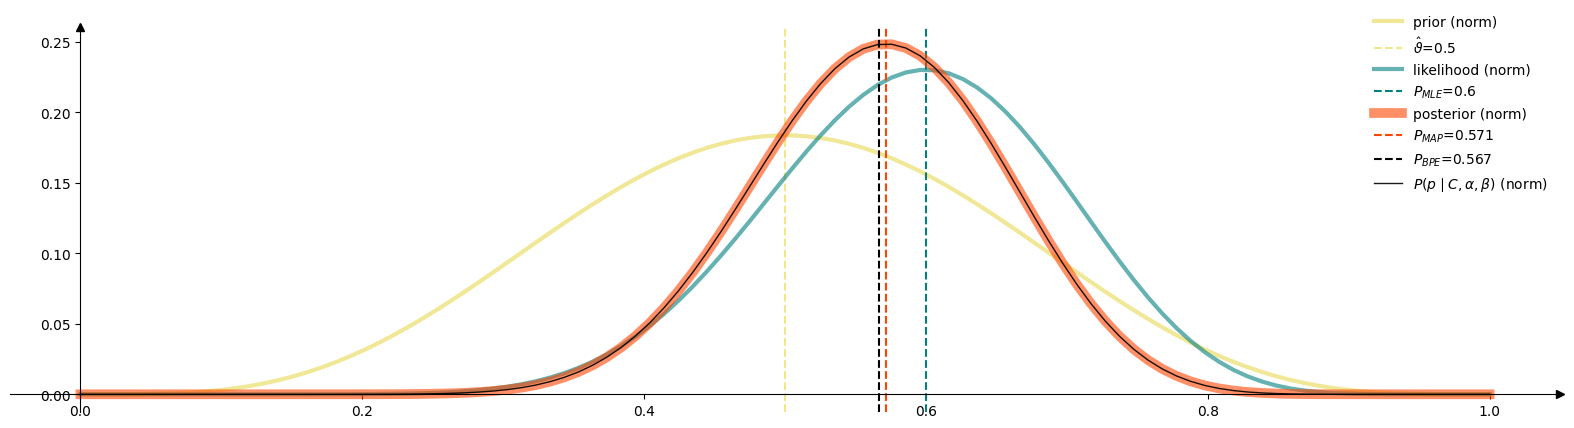

In [270]:
fig, ax=plt.subplots(1, 1,figsize=(5*4,5))
x = np.linspace(0, 1, 100)

alpha_, beta_=sympy.symbols('alpha beta', positive=True)
x_, p_=sympy.symbols('x p', positive=True)

# prior
beta_dis=sympy.Piecewise(
    (0, p_ < 0),
    (0, p_ > 1),
    (p_**(alpha_-1)*(1-p_)**(beta_-1)/(sympy.gamma(alpha_)*sympy.gamma(beta_)/sympy.gamma(alpha_+beta_)), True))
print('prior density:')
display(beta_dis)
beta_dis_=sympy.lambdify([p_,alpha_,beta_],beta_dis,"numpy")
a,b=5,5
ax.plot(x,preprocessing.normalize([beta_dis_(x, a, b)])[0], lw=3, alpha=0.9, label=f'prior (norm)',color='khaki') 
ax.axvline(x=0.5,color='khaki', linestyle="--",label='$\\hat{\\vartheta}$=0.5')

# likelihood (normalized)
pmf=p_**x_*(1-p_)**(1-x_)
L=np.prod([pmf.subs(x_, i) for i in coin_data['tossing']])
L_=sympy.lambdify(p_,L,"numpy")
print('Likelihood density:')
display(L)
ax.plot(x,preprocessing.normalize([L_(x)])[0], lw=3, alpha=0.6, label=f'likelihood (norm)',color='teal') 
ax.axvline(x=coin_bn.get_state_probability({'tossing':1}),color='teal', linestyle="--",label='$P_{{MLE}}$={}'.format(coin_bn.get_state_probability({'tossing':1})))

# posterior
posterior=L*beta_dis 
print('posterior density:')
display(posterior)
posterior_=sympy.lambdify([p_,alpha_,beta_],posterior,"numpy")
ax.plot(x,preprocessing.normalize([posterior_(x,a,b)])[0], lw=7, alpha=0.6, label=f'posterior (norm)',color='orangered')
ax.axvline(x=tossing_map_theta,color='orangered', linestyle="--",label='$P_{{MAP}}$={:.3f}'.format(tossing_map_theta))

# Bayesian Parameter Estimation
ax.axvline(x=coin_be_p.values[1],color='k', linestyle="--",label='$P_{{BPE}}$={:.3f}'.format(coin_be_p.values[1]))
ax.plot(x,preprocessing.normalize([beta_dis_(x, a+head_num, b+tail_num)])[0], lw=1, alpha=0.9, label=f'$P(p \\mid C, \\alpha, \\beta)$ (norm)',color='k') 

usda_vis.plot_style_axis_A(ax)
plt.legend(loc='right',frameon=False,bbox_to_anchor=(1, 0.8))
plt.show()

对水果味道的试验，从上述 MLE 的表现来看，存在对数据过度拟合的问题。例如其中对于$fruit$的状态`banana`，当$size$的状态为`small`时，$tasty$状态`yes`的概率为0。这里，只观测到了香蕉为小个时的1个样本为好吃，因为样本量少，这很难确定小个香蕉是否不好吃。如果观测到的数据不能代表变量的潜在分布，则 MLE 估计的结果往往并不理想。

在估计 BN 参数时，缺乏数据往往是常见的一个问题；另，如果一个变量节点有3个父节点，每个父节点各含有10个状态，那么状态统计为$10^3=1000$，这使得 MLE 对于学习 BN 的参数非常的不稳定。而为减少 MLE 过度拟合，使用贝叶斯参数估计实现。

In [11]:
fruit_bn.fit(fruit_data, estimator=BayesianEstimator, prior_type="BDeu") # default equivalent_sample_size=5
for cpd in fruit_bn.get_cpds():
    print(cpd)

+---------------+-----+
| fruit(apple)  | 0.5 |
+---------------+-----+
| fruit(banana) | 0.5 |
+---------------+-----+
+------------+---------------------+---------------------+---------------------+--------------------+
| fruit      | fruit(apple)        | fruit(apple)        | fruit(banana)       | fruit(banana)      |
+------------+---------------------+---------------------+---------------------+--------------------+
| size       | size(large)         | size(small)         | size(large)         | size(small)        |
+------------+---------------------+---------------------+---------------------+--------------------+
| tasty(no)  | 0.30952380952380953 | 0.38235294117647056 | 0.22413793103448276 | 0.7222222222222222 |
+------------+---------------------+---------------------+---------------------+--------------------+
| tasty(yes) | 0.6904761904761905  | 0.6176470588235294  | 0.7758620689655172  | 0.2777777777777778 |
+------------+---------------------+---------------------+------

### 3.5.4.2 结构学习

#### 1）基于得分（Score-based）的结构估计

* 得分函数（Scoring functions）

基于得分的方法是把结构学习问题作为一个优化问题来解决，而衡量模型和数据之间拟合度的常用得分函数有 BDeu 或 K2 等贝叶斯狄利克雷分数（Bayesian Dirichlet scores）和 BIC (也称为 MDL)等贝叶斯信息准则（ Bayesian Information Criterion）等。基于数据集对每个候选结构打分，得分高的结构为最优结构。下述案例生成了一个假的数据集，包含三个随机变量$(X,Y,Z)$，因为$Z=X+Y$，因此可知结构为$X \rightarrow Z \leftarrow Y$的 v-结构。为了验证`BDeu`、`K2`和`BIC`得分函数，假设模型`model1`符合 v-结构；而模型`model2`为$X \leftarrow Z \rightarrow Y$。从计算结果得知`model1`的各得分均高于`model2`，因此估计$X \rightarrow Z \leftarrow Y$为最优结构。

In [ ]:
import pandas as pd
import numpy as np
from pgmpy.estimators import BDeuScore, K2Score, BicScore,ExhaustiveSearch,HillClimbSearch,PC,MmhcEstimator
from pgmpy.estimators.CITests import chi_square
from pgmpy.models import BayesianNetwork

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# create random data sample with 3 variables, where Z is dependent on X, Y:
data = pd.DataFrame(np.random.randint(0, 4, size=(5000, 2)), columns=list('XY'))
data['Z'] = data['X'] + data['Y']

bdeu = BDeuScore(data, equivalent_sample_size=5)
k2 = K2Score(data)
bic = BicScore(data)

model1 = BayesianNetwork([('X', 'Z'), ('Y', 'Z')])  # X -> Z <- Y
model2 = BayesianNetwork([('X', 'Z'), ('X', 'Y')])  # Y <- X -> Z

print(f'model1:\nBDeuScore=\t{bdeu.score(model1)}\nK2Score=\t{k2.score(model1)}\nBicScore=\t{bic.score(model1)}')
print(f'model2:\nBDeuScore=\t{bdeu.score(model2)}\nK2Score=\t{k2.score(model2)}\nBicScore=\t{bic.score(model2)}')

model1:
BDeuScore=	-13938.698111661924
K2Score=	-14329.548959442178
BicScore=	-14294.73527862384
model2:
BDeuScore=	-20909.028603685794
K2Score=	-20935.843622693803
BicScore=	-20953.069518357206


分解分数，即给出待估计变量的潜在父变量情况下的得分。例如下述示例，给出了随机变量$Z$潜在不同父变量的得分，可知当父变量为$X,Y$时有最高得分。

In [ ]:
print(bdeu.local_score('Z', parents=[]))
print(bdeu.local_score('Z', parents=['X']))
print(bdeu.local_score('Z', parents=['X', 'Y']))

-9209.01947362572
-6991.892692505713
-57.120667260368634


* 结构搜索（Search strategies）

在随机变量的数量上，DAG 的搜索空间是超指数的（super-exponential）。对于少量变量节点的情况可以用穷举（完全）搜索`ExhaustiveSearch`返回得分最高的一个；对于含有大量节点的问题，如果使用穷举法，计算成本较高，因此通常使用启发式搜索策略（heuristic search strategies）估计最优结构。

对于只有3个变量的贝叶斯网络结构估计，使用穷举法总共估计有25个 DAGs，其中$X \rightarrow Z \leftarrow Y$的结构得分最高。

In [ ]:
es = ExhaustiveSearch(data, scoring_method=bic)
best_model = es.estimate()
print(len(list(es.all_dags())))
print(best_model.edges())

print("\nAll DAGs by score:")
for score, dag in reversed(es.all_scores()):
    print(score, dag.edges())

25
[('X', 'Z'), ('Y', 'Z')]

All DAGs by score:
-14294.73527862384 [('X', 'Z'), ('Y', 'Z')]
-14330.662857922875 [('Y', 'X'), ('Z', 'X'), ('Z', 'Y')]
-14330.662857922875 [('X', 'Z'), ('Y', 'Z'), ('Y', 'X')]
-14330.662857922875 [('X', 'Y'), ('Z', 'X'), ('Z', 'Y')]
-14330.662857922875 [('X', 'Y'), ('X', 'Z'), ('Z', 'Y')]
-14330.662857922875 [('X', 'Y'), ('X', 'Z'), ('Y', 'Z')]
-14330.662857922876 [('Y', 'Z'), ('Y', 'X'), ('Z', 'X')]
-16511.124417627434 [('X', 'Y'), ('Z', 'Y')]
-16513.616802541135 [('Y', 'X'), ('Z', 'X')]
-18734.18799443991 [('Z', 'X'), ('Z', 'Y')]
-18734.18799443991 [('X', 'Z'), ('Z', 'Y')]
-18734.187994439915 [('Y', 'Z'), ('Z', 'X')]
-20914.64955414447 [('Z', 'Y')]
-20914.649554144475 [('Y', 'Z')]
-20917.141939058172 [('Z', 'X')]
-20917.141939058172 [('X', 'Z')]
-20950.577133443505 [('Y', 'X'), ('Z', 'Y')]
-20950.57713344351 [('X', 'Y'), ('Y', 'Z')]
-20950.577133443512 [('Y', 'Z'), ('Y', 'X')]
-20953.069518357206 [('X', 'Y'), ('Z', 'X')]
-20953.069518357206 [('X', 'Y'), 

如果包含较多的变量节点，则最好使用启发式搜索。例如生成有8个特征列的数据集，其中$A := B+C$，$H=G-A$，应用爬山算法（hill climbing）计算，从下述结果可以观察到$A,B,C$之间，$A,G,H$之间出现有向边，而其它随机变量不具有相关性，相互独立，节点之间无边连接。

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('A', 'H'), ('A', 'B'), ('A', 'C'), ('C', 'B'), ('G', 'H')]


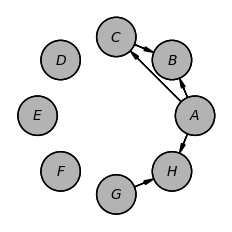

In [ ]:
# create some data with dependencies
data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']

hc = HillClimbSearch(data)
best_model = hc.estimate(scoring_method=BicScore(data))
print(best_model.edges())
model_daft=best_model.to_daft()
model_daft.render(dpi=100);

#### 2）基于约束（Constrain-based）的结构估计

从数据集中构建 DAG 的一种非常直接的方式是：使用假设检验识别数据集中特征变量的独立性；根据确定的独立性构建 DAG。

* （有条件）独立性检验（（Conditional） Independence Tests）

数据集中特征变量的独立性测试可以使用 chi2 条件独立性测试`chi_square`方法识别。例如构建有$A := B+C$，$H=G-A,E \propto F$关系，下述判断结果满足上述关系，例如$B,H$之间并不独立，因为$B,H$之间存在一个节点$A$，使得$B,H$节点间存在有效迹，节点$B$的影响可以流动到节点$A$；但是如果给定节点$A$，则$B$和$H$之间独立。

In [ ]:
data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']
data['E'] *= data['F']

print(chi_square(X='B', Y='H', Z=[], data=data, significance_level=0.05))          # dependent
print(chi_square(X='B', Y='E', Z=[], data=data, significance_level=0.05))          # independent
print(chi_square(X='B', Y='H', Z=['A'], data=data, significance_level=0.05))       # independent
print(chi_square(X='A', Y='G', Z=[], data=data, significance_level=0.05))          # independent
print(chi_square(X='A', Y='G', Z=['H'], data=data, significance_level=0.05))       # dependent

False
True
False
True
False


* DAG（模式）构建（DAG (pattern) construction）

借助数据集中特征变量的独立性测试方法，可以分3步从数据集中构建 DAG：

1. 使用`build_skeleton`方法构建一个无向骨架（基本结构）（undirected skeleton）；
2. 使用`skeleton_to_pdag`方法定向强制的边获得部分有向无环图（partially directed acyclid graph，PDAG）（DAGs 的 I-等阶类（ I-equivalence class））；
3. 基于 PDAG，使用`to_dag`方法保守的定向剩余的边构建 DAG。

步骤1和2使用了称为 PC 的算法<sup>[6]</sup>。

In [ ]:
est = PC(data)
skel, seperating_sets = est.build_skeleton(significance_level=0.01)
print("Undirected edges: ", skel.edges())

pdag = est.skeleton_to_pdag(skel, seperating_sets)
print("PDAG edges:       ", pdag.edges())

model = pdag.to_dag()
print("DAG edges:        ", model.edges())

  0%|          | 0/5 [00:00<?, ?it/s]

Undirected edges:  [('A', 'B'), ('A', 'C'), ('A', 'H'), ('E', 'F'), ('G', 'H')]
PDAG edges:        [('G', 'H'), ('C', 'A'), ('A', 'H'), ('B', 'A'), ('F', 'E'), ('E', 'F')]
DAG edges:         [('G', 'H'), ('C', 'A'), ('A', 'H'), ('B', 'A'), ('F', 'E')]


`estimate`方法可以将上述3个步骤书写为一行代码。

In [ ]:
print(est.estimate(significance_level=0.01).edges())

  0%|          | 0/5 [00:00<?, ?it/s]

[('G', 'H'), ('C', 'A'), ('A', 'H'), ('B', 'A'), ('F', 'E')]


#### 3）混合（Hybrid）结构设计

MMHC（Max-Min Hill-Climbing）算法<sup>[7]</sup>结合了基于约束和基于得分的方法，含有两个步骤：

1. 使用基于约束的结构估计从数据集中学习无向图的基本结构；
2. 使用基于得分的结构估计定向边。

In [ ]:
data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']
data['E'] *= data['F']

mmhc = MmhcEstimator(data)
skeleton = mmhc.mmpc()
print("Part 1) Skeleton: ", skeleton.edges())

# use hill climb search to orient the edges:
hc = HillClimbSearch(data)
model = hc.estimate(tabu_length=10, white_list=skeleton.to_directed().edges(), scoring_method=BDeuScore(data))
print("Part 2) Model:    ", model.edges())

Part 1) Skeleton:  [('A', 'C'), ('A', 'B'), ('A', 'H'), ('A', 'E'), ('A', 'F'), ('B', 'G'), ('C', 'H'), ('C', 'D'), ('C', 'F'), ('E', 'F'), ('E', 'G'), ('G', 'H')]


  0%|          | 0/1000000 [00:00<?, ?it/s]

Part 2) Model:     [('A', 'H'), ('B', 'A'), ('C', 'A'), ('F', 'E'), ('G', 'H')]


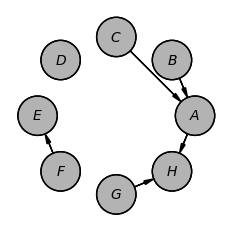

In [ ]:
model_daft=model.to_daft()
model_daft.render(dpi=100);

可以分步骤计算，也可以用`MmhcEstimator.estimate()`方法合并为一个步骤计算。

In [ ]:
data = pd.DataFrame(np.random.randint(0, 2, size=(2500, 4)), columns=list('XYZW'))
data['sum'] = data.sum(axis=1)
est = MmhcEstimator(data)
model = est.estimate()
print(model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('X', 'sum'), ('Y', 'sum'), ('Z', 'sum'), ('W', 'sum')]


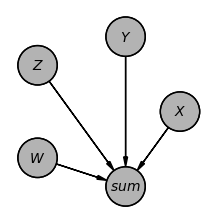

In [ ]:
model_daft=model.to_daft()
model_daft.render(dpi=100);

### 附：正定（半正定）(Positive (Semi)-Definite)协方差矩阵<sup>[8]</sup>

协方差（covariance）表示特征向量之间的关系，正协方差表示特征值一起同向变化；负协方差表示特征反向变化。对于两个随机变量有$Cov(x, y) = E[x - \mu_x][y - \mu_y]^T $；对于一个随机向量有$Cov(x) = E[x - \mu][x - \mu]^T $，式中均值$\mu = \frac{1}{n}\sum_{i=1}^n x_i$；对于有$n$个观测值（样本）的$m$个随机特征向量，协方差矩阵为$Cov_{ij} = E[x_i - \mu_i][x_j - \mu_j] = \sigma_{ij},x_i \in \mathbb{R}^{m\times n}$。

为了方便观察和分类协方差矩阵的变化趋势关系，结合二阶函数几何形态的凹凸性分类有，

1. 如果一个矩阵是正定的（positive definite），它有一个绝对最小值，且在所有轴上都达到了最小值。如果一个$n \times n$对称矩阵（symmetric matrix）$M$是正定的，满足$x^TMx \gt 0 , x \in \mathbb{R}^{1 \times n}$；
2. 如果一个矩阵是半正定的（positive semi-definite），它至少在一个轴向量上有一个极小值。如果一个$n \times n$对称矩阵（symmetric matrix）$M$是半正定的，满足$x^TMx \geq 0,x \in \mathbb{R}^{n}$；
3. 如果一个矩阵是负定的（negative definite ），它有一个绝对最大值，且在所有轴上都达到了最大值；
4. 如果一个矩阵是半负定的（negative semi-definite），它至少在一个轴向量上有一个极大值；
5. 如果一个矩阵是无限的（indfinite），它有一个鞍点。

In [21]:
from datascience import *
from prob140 import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight')

In [22]:
%load_ext autoreload 
%autoreload 2 
import usda.data_visual as usda_vis
import usda.pgm as usda_pgm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


* 正定的（positive definite）

In [23]:
def quadratic_form_positive_definite(x,y):
    return x**2+y**2

Plot_3d(x_limits=(-2,2), y_limits=(-2,2), f=quadratic_form_positive_definite, cstride=4, rstride=4,interactive=True)   

interactive(children=(FloatSlider(value=20.0, description='elevation', max=90.0, step=1.0), FloatSlider(value=…

* 半正定的（positive semi-definite）

In [24]:
def quadratic_form_positive_semi_definite(x,y):
    return x**2

Plot_3d(x_limits=(-2,2), y_limits=(-2,2),f=quadratic_form_positive_semi_definite, cstride=4, rstride=4,interactive=True)   

interactive(children=(FloatSlider(value=20.0, description='elevation', max=90.0, step=1.0), FloatSlider(value=…

* 负定的（negative definite ）

In [25]:
def quadratic_form_negative_definite(x,y):
    return -x**2-y**2

Plot_3d(x_limits=(-2,2), y_limits=(-2,2), f=quadratic_form_negative_definite, cstride=4, rstride=4,interactive=True)   

interactive(children=(FloatSlider(value=20.0, description='elevation', max=90.0, step=1.0), FloatSlider(value=…

* 半负定的（negative semi-definite）

In [26]:
def quadratic_form_negative_semi_definite(x,y):
    return -x**2

Plot_3d(x_limits=(-2,2), y_limits=(-2,2),f=quadratic_form_negative_semi_definite, cstride=4, rstride=4,interactive=True) 

interactive(children=(FloatSlider(value=20.0, description='elevation', max=90.0, step=1.0), FloatSlider(value=…

* 无限的（indfinite）

In [27]:
def quadratic_form_indefinite(x,y):
    return x**2-y**2

Plot_3d(x_limits=(-2,2), y_limits=(-2,2),f=quadratic_form_indefinite, cstride=4, rstride=4,interactive=True) 

interactive(children=(FloatSlider(value=20.0, description='elevation', max=90.0, step=1.0), FloatSlider(value=…

使用`covariance_test`方法判断协方差矩阵的类别，包括是否是正定、半正定的，是否为对称矩阵，是否为正行列式（Positive Determinant）及特征值（Eigen Values）是否为正。

In [73]:
cov=np.array([[4, 2, -2], 
              [2, 5, -5], 
              [-2, -5, 8]])
usda_pgm.covariance_test(cov,[0,1])

{'Positive Definite': True,
 'Positive Semi-Definite': True,
 'Symmetric': True,
 'Positive Determinant': True,
 'Eigen Values, Positivity': True}

---

注释（Notes）：

① pgmpy库， （<https://github.com/pgmpy/pgmpy>）。

② pgmpy在线手册，（<https://pgmpy.org/>）。

③ pomegranate库，（<https://github.com/jmschrei/pomegranate>）。

④ pomegranate在线手册，（<https://github.com/jmschrei/pomegranate/tree/master/docs/tutorials>）。

⑤ PGM_PyLib库，（<https://github.com/jona2510/PGM_PyLib>）。

⑥ PyGModels库，（<https://github.com/D-K-E/graphical-models/>）。

⑦ PyGModels在线手册，（<https://d-k-e.github.io/graphical-models/html/index.html>）。

⑧ pyGMs库，（<https://github.com/ihler/pyGMs>）。

⑨ pgmPy库，（<https://github.com/indapa/pgmPy>）。

⑩ pgmPy课程，（<https://www.coursera.org/learn/probabilistic-graphical-models>）。

⑪ pgm库，（<https://github.com/paulorauber/pgm>）。

⑫ Skearn（scikit-learn）的GaussianNB类，（<https://scikit-learn.org/stable/modules/naive_bayes.html)>）。

⑬ InVEST（Integrated Valuation of Ecosystem Services and Tradeoffs），（<https://naturalcapitalproject.stanford.edu/software/invest>）。

⑭ daft库，（<https://docs.daft-pgm.org/en/latest/>）。

参考文献（References）:

[1] Koller D, Friedman N. Probabilistic Graphical Models : Principles and Techniques / Daphne Koller and Nir Friedman. MIT Press; 2009.（[美]Daphne Koller [以色列]Nir Friedman 著, 王飞跃、韩素青 译出版社:清华大学出版社出版时间:2015.03）

[2] Ankan A, Panda A. Mastering Probabilistic Graphical Models Using Python : Master Probabilistic Graphical Models by Learning through Real-World Problems and Illustrative Code Examples in Python / Ankur Ankan, Abinash Panda. 1st edition. Packt Publishing; 2015.

[3] Sucar LE. Probabilistic Graphical Models : Principles and Applications / Luis Enrique Sucar. Second edition. Springer; 2021. doi:10.1007/978-3-030-61943-5.

[4] Naive Bayes, <https://scikit-learn.org/stable/modules/naive_bayes.html>.

[5] Heinrich, G. Parameter estimation for text analysis.(2008).

[6] Neapolitan, R. E. Learning Bayesian Networks. (Pearson Prentice Hall, 2004).

[7] Tsamardinos, I., Brown, L. E. & Aliferis, C. F. The max-min hill-climbing Bayesian network structure learning algorithm. Mach Learn 65, 31–78 (2006).

[8] Why Covariance Matrix Should Be Positive Semi-Definite, Tests Using Breast Cancer Dataset，<https://gowrishankar.info/blog/why-covariance-matrix-should-be-positive-semi-definite-tests-using-breast-cancer-dataset/>.